In [1]:
# Cell 1: Imports and Database Connection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import psycopg2
import json
import warnings
warnings.filterwarnings('ignore')

# Database connection
def load_data():
    conn = psycopg2.connect(
        host="localhost",
        port=5434,
        database="vv8_backend",
        user="vv8",
        password="vv8"

    )
    
    query = "SELECT * FROM multicore_static_info_known_companies"
    df = pd.read_sql(query, conn)
    
    conn.close()
    
    print(f"Loaded {len(df)} scripts from database")
    return df

df = load_data()


Loaded 2229 scripts from database


## Remove negative labels

In [2]:
# Cell 2: Analyze Vendor Distribution (Positives Only)
# Filter positive scripts to analyze vendor distribution
positive_df = df[df['label'] == 1].copy()
negative_df = df[df['label'] == 0].copy()

print("Dataset Overview:")
print(f"Total scripts: {len(df)}")
print(f"Positive scripts: {len(positive_df)}")
print(f"Negative scripts: {len(negative_df)}")
print(f"Unique vendors in positives: {positive_df['vendor'].nunique()}")
print(f"Null vendors in negatives: {negative_df['vendor'].isnull().sum()}")

# Vendor distribution analysis (positives only)
vendor_counts = positive_df['vendor'].value_counts()
print(f"\nVendor Distribution (Positive Scripts Only):")
print(vendor_counts)

# Categorize vendors by frequency
high_volume_vendors = vendor_counts[vendor_counts > 20].index.tolist()
medium_volume_vendors = vendor_counts[(vendor_counts >= 5) & (vendor_counts <= 20)].index.tolist()
low_volume_vendors = vendor_counts[vendor_counts < 5].index.tolist()

print(f"\nVendor Categories:")
print(f"High volume (>20 scripts): {len(high_volume_vendors)} vendors")
print(f"  - {high_volume_vendors}")
print(f"Medium volume (5-20 scripts): {len(medium_volume_vendors)} vendors") 
print(f"  - {medium_volume_vendors}")
print(f"Low volume (<5 scripts): {len(low_volume_vendors)} vendors")
print(f"  - {low_volume_vendors}")


Dataset Overview:
Total scripts: 2229
Positive scripts: 232
Negative scripts: 244
Unique vendors in positives: 18
Null vendors in negatives: 244

Vendor Distribution (Positive Scripts Only):
vendor
Iovation      81
Forter        53
Human         27
BioCatch      21
Behaviosec     9
Yofi           8
Sardine        6
Nudata         6
PingOne        5
Cheq           4
Accertify      3
Feedzai        2
Transmit       2
Datadome       1
Callsign       1
Threatmark     1
GroupIB        1
Utarget        1
Name: count, dtype: int64

Vendor Categories:
High volume (>20 scripts): 4 vendors
  - ['Iovation', 'Forter', 'Human', 'BioCatch']
Medium volume (5-20 scripts): 5 vendors
  - ['Behaviosec', 'Yofi', 'Sardine', 'Nudata', 'PingOne']
Low volume (<5 scripts): 9 vendors
  - ['Cheq', 'Accertify', 'Feedzai', 'Transmit', 'Datadome', 'Callsign', 'Threatmark', 'GroupIB', 'Utarget']


## Test Train Split

In [3]:
# Fixed Cell: Proper handling of pandas arrays in pd.isna()
def create_working_vendor_agnostic_features(df):
    """
    Create vendor-agnostic features with proper handling of pandas list fields
    and include aggregation-related features.
    """
    features_list = []

    def is_null_or_empty(value):
        if value is None:
            return True
        try:
            if hasattr(value, '__len__') and not isinstance(value, (str, dict)):
                if len(value) == 0:
                    return True
                if hasattr(value, 'dtype') and 'bool' in str(value.dtype):
                    return False
                return False
            return pd.isna(value)
        except:
            return value is None

    for idx, row in df.iterrows():
        try:
            features = {}

            # Safe extraction
            behavioral_access = row['behavioral_apis_access_count'] if row['behavioral_apis_access_count'] is not None else {}
            fp_access = row['fingerprinting_api_access_count'] if row['fingerprinting_api_access_count'] is not None else {}
            behavioral_sources = row['behavioral_source_apis'] if row['behavioral_source_apis'] is not None else []
            fp_sources = row['fingerprinting_source_apis'] if row['fingerprinting_source_apis'] is not None else []
            sink_data = row['apis_going_to_sink'] if row['apis_going_to_sink'] is not None else {}

            # === AGGREGATION FEATURES ===
            max_agg = row.get('max_api_aggregation_score', 0)
            behavioral_agg = row.get('behavioral_api_agg_count', 0)
            fp_agg = row.get('fp_api_agg_count', 0)

            max_agg = 0 if (pd.isna(max_agg) or max_agg == -1) else max_agg
            behavioral_agg = 0 if (pd.isna(behavioral_agg) or behavioral_agg == -1) else behavioral_agg
            fp_agg = 0 if (pd.isna(fp_agg) or fp_agg == -1) else fp_agg

            features['max_api_aggregation_score'] = max_agg
            features['behavioral_api_agg_count'] = behavioral_agg
            features['fp_api_agg_count'] = fp_agg
            features['total_aggregation_count'] = behavioral_agg + fp_agg
            features['has_aggregation'] = int(max_agg > 0)

            total_agg = behavioral_agg + fp_agg
            if total_agg > 0:
                features['behavioral_agg_ratio'] = behavioral_agg / total_agg
                features['fp_agg_ratio'] = fp_agg / total_agg
            else:
                features['behavioral_agg_ratio'] = 0
                features['fp_agg_ratio'] = 0

            features['has_behavioral_aggregation'] = int(behavioral_agg > 0)
            features['has_fp_aggregation'] = int(fp_agg > 0)
            features['has_both_aggregation_types'] = int(behavioral_agg > 0 and fp_agg > 0)

            # === BEHAVIORAL FOCUS RATIOS ===
            total_behavioral = len(behavioral_sources) if behavioral_sources is not None else 0
            total_fp = len(fp_sources) if fp_sources is not None else 0
            total_apis = total_behavioral + total_fp

            if total_apis > 0:
                features['behavioral_focus_ratio'] = total_behavioral / total_apis
                features['fp_focus_ratio'] = total_fp / total_apis
            else:
                features['behavioral_focus_ratio'] = 0
                features['fp_focus_ratio'] = 0

            # === INTERACTION PATTERN DIVERSITY ===
            event_types = set()
            for api in behavioral_sources:
                api_str = str(api)
                if 'MouseEvent' in api_str:
                    event_types.add('mouse')
                elif 'KeyboardEvent' in api_str:
                    event_types.add('keyboard')
                elif 'TouchEvent' in api_str or 'Touch.' in api_str:
                    event_types.add('touch')
                elif 'PointerEvent' in api_str:
                    event_types.add('pointer')
                elif 'DeviceMotion' in api_str or 'DeviceOrientation' in api_str:
                    event_types.add('device')
                elif 'WheelEvent' in api_str:
                    event_types.add('wheel')
                elif 'FocusEvent' in api_str:
                    event_types.add('focus')

            features['interaction_diversity'] = len(event_types)
            features['has_multi_input_types'] = int(len(event_types) >= 3)

            # === SOPHISTICATION PATTERNS ===
            coordinate_apis = 0
            timing_apis = 0
            device_apis = 0

            for api in behavioral_sources:
                api_str = str(api)
                if any(coord in api_str for coord in ['clientX', 'clientY', 'screenX', 'screenY', 'pageX', 'pageY']):
                    coordinate_apis += 1
                if any(timing in api_str for timing in ['timeStamp', 'interval']):
                    timing_apis += 1
                if 'DeviceMotion' in api_str or 'DeviceOrientation' in api_str:
                    device_apis += 1

            features['tracks_coordinates'] = int(coordinate_apis > 0)
            features['tracks_timing'] = int(timing_apis > 0)
            features['tracks_device_motion'] = int(device_apis > 0)
            features['sophistication_score'] = features['tracks_coordinates'] + features['tracks_timing'] + features['tracks_device_motion']

            # === FINGERPRINTING CATEGORIES ===
            navigator_apis = 0
            screen_apis = 0
            canvas_apis = 0
            audio_apis = 0

            for api in fp_sources:
                api_str = str(api)
                if 'Navigator.' in api_str:
                    navigator_apis += 1
                if 'Screen.' in api_str:
                    screen_apis += 1
                if 'Canvas' in api_str or 'WebGL' in api_str:
                    canvas_apis += 1
                if 'Audio' in api_str:
                    audio_apis += 1

            features['uses_navigator_fp'] = int(navigator_apis > 0)
            features['uses_screen_fp'] = int(screen_apis > 0)
            features['uses_canvas_fp'] = int(canvas_apis > 0)
            features['uses_audio_fp'] = int(audio_apis > 0)
            features['fp_approach_diversity'] = (
                features['uses_navigator_fp'] + features['uses_screen_fp'] +
                features['uses_canvas_fp'] + features['uses_audio_fp']
            )

            # === ACCESS INTENSITY ===
            total_behavioral_accesses = sum(behavioral_access.values()) if behavioral_access else 0
            total_fp_accesses = sum(fp_access.values()) if fp_access else 0
            total_accesses = total_behavioral_accesses + total_fp_accesses

            features['collection_intensity'] = total_accesses / max(total_apis, 1)
            features['behavioral_access_ratio'] = total_behavioral_accesses / max(total_accesses, 1) if total_accesses > 0 else 0

            # === DATA FLOW PATTERNS ===
            features['has_data_collection'] = int(len(sink_data) > 0) if sink_data else 0
            features['collection_method_diversity'] = len(sink_data) if sink_data else 0

            # === BINARY TRACKING CAPABILITIES ===
            features['tracks_mouse'] = int(any('MouseEvent' in str(api) for api in behavioral_sources)) if behavioral_sources else 0
            features['tracks_keyboard'] = int(any('KeyboardEvent' in str(api) for api in behavioral_sources)) if behavioral_sources else 0
            features['tracks_touch'] = int(any('TouchEvent' in str(api) or 'Touch.' in str(api) for api in behavioral_sources)) if behavioral_sources else 0
            features['tracks_pointer'] = int(any('PointerEvent' in str(api) for api in behavioral_sources)) if behavioral_sources else 0

            # === COMPLEXITY CLASSIFICATION ===
            if total_apis == 0:
                features['complexity_tier'] = 0
            elif total_apis <= 5:
                features['complexity_tier'] = 1
            elif total_apis <= 15:
                features['complexity_tier'] = 2
            else:
                features['complexity_tier'] = 3

            # === BALANCE METRICS ===
            features['is_behavioral_heavy'] = int(total_behavioral > total_fp and total_behavioral > 5)
            features['is_fp_heavy'] = int(total_fp > total_behavioral and total_fp > 5)
            features['is_balanced_tracker'] = int(abs(total_behavioral - total_fp) <= 3 and total_apis > 5)

            # === METADATA ===
            features['script_id'] = int(row['script_id'])
            features['label'] = int(row['label'])
            features['vendor'] = row['vendor'] if row['vendor'] is not None else 'negative'

            features_list.append(features)

        except Exception as e:
            print(f"Error processing script {row.get('script_id', 'unknown')}: {e}")
            continue

    return pd.DataFrame(features_list)

# Create the working features
print("Creating vendor-agnostic features (fixed version)...")
agnostic_features_df = create_working_vendor_agnostic_features(df)
feature_cols = [col for col in agnostic_features_df.columns if col not in ['script_id', 'label', 'vendor']]
print(f"Created {len(feature_cols)} vendor-agnostic features for {len(agnostic_features_df)} scripts")

# Check variance and distributions
print(f"\nFeature variance check:")
positive_samples = agnostic_features_df[agnostic_features_df['label'] == 1]
for col in feature_cols[:10]:
    if len(positive_samples) > 0:
        variance = positive_samples[col].var()
        unique_vals = positive_samples[col].nunique()
        mean_val = positive_samples[col].mean()
        print(f"{col}: mean={mean_val:.3f}, var={variance:.3f}, unique={unique_vals}")

# Compare positive vs negative
print(f"\nPositive vs Negative comparison:")
neg_samples = agnostic_features_df[agnostic_features_df['label'] == 0]
print("Feature | Pos_Mean | Neg_Mean | Difference")
print("-" * 50)
for col in feature_cols[:10]:
    if len(positive_samples) > 0 and len(neg_samples) > 0:
        pos_mean = positive_samples[col].mean()
        neg_mean = neg_samples[col].mean()
        diff = pos_mean - neg_mean
        print(f"{col[:20]:20} | {pos_mean:8.3f} | {neg_mean:8.3f} | {diff:10.3f}")

Creating vendor-agnostic features (fixed version)...
Created 35 vendor-agnostic features for 2229 scripts

Feature variance check:
max_api_aggregation_score: mean=15.927, var=61.627, unique=30
behavioral_api_agg_count: mean=10.009, var=56.329, unique=22
fp_api_agg_count: mean=5.918, var=49.443, unique=18
total_aggregation_count: mean=15.927, var=61.627, unique=30
has_aggregation: mean=0.991, var=0.009, unique=2
behavioral_agg_ratio: mean=0.609, var=0.152, unique=31
fp_agg_ratio: mean=0.383, var=0.150, unique=31
has_behavioral_aggregation: mean=0.871, var=0.113, unique=2
has_fp_aggregation: mean=0.543, var=0.249, unique=2
has_both_aggregation_types: mean=0.422, var=0.245, unique=2

Positive vs Negative comparison:
Feature | Pos_Mean | Neg_Mean | Difference
--------------------------------------------------
max_api_aggregation_ |   15.927 |    4.836 |     11.091
behavioral_api_agg_c |   10.009 |    2.045 |      7.964
fp_api_agg_count     |    5.918 |    2.791 |      3.127
total_aggregati

In [4]:
agnostic_features_df.shape

(2229, 38)

# Feature Selection

Running simple feature selection...
🔍 SIMPLE FEATURE SELECTION
     max_api_aggregation_score  behavioral_api_agg_count  fp_api_agg_count  \
0                          0.0                       0.0               0.0   
1                          0.0                       0.0               0.0   
2                         18.0                      18.0               0.0   
3                          2.0                       2.0               0.0   
4                          2.0                       1.0               1.0   
..                         ...                       ...               ...   
471                        9.0                       9.0               0.0   
472                       11.0                       2.0               9.0   
473                       15.0                      15.0               0.0   
474                       18.0                      18.0               0.0   
475                       15.0                      15.0               0.0   



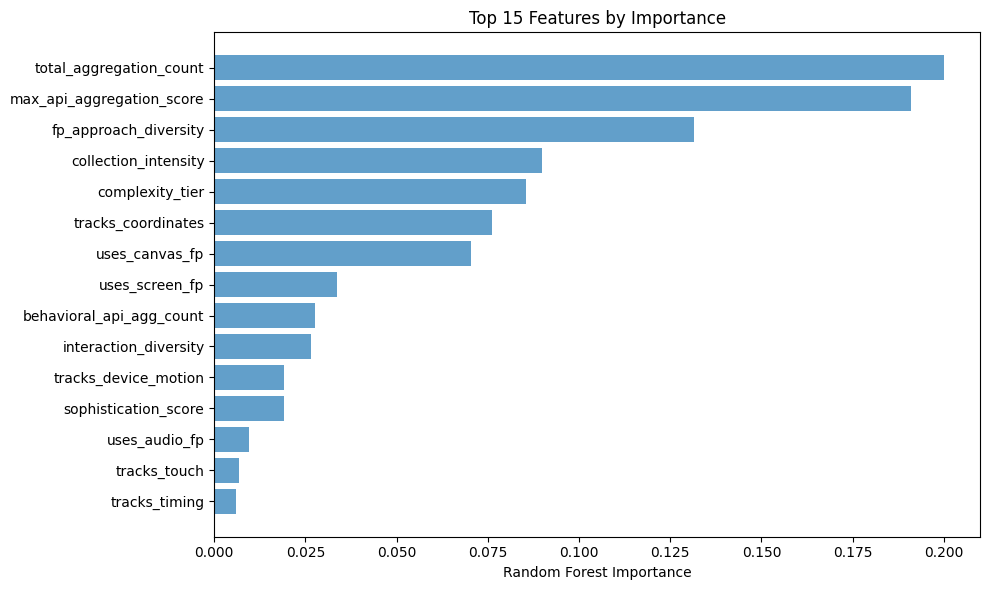


🎯 SELECTED FEATURES FOR MODELING:
 1. total_aggregation_count   (importance: 0.1999)
 2. max_api_aggregation_score (importance: 0.1910)
 3. fp_approach_diversity     (importance: 0.1314)
 4. collection_intensity      (importance: 0.0898)
 5. complexity_tier           (importance: 0.0854)
 6. tracks_coordinates        (importance: 0.0761)
 7. uses_canvas_fp            (importance: 0.0703)
 8. uses_screen_fp            (importance: 0.0337)
 9. behavioral_api_agg_count  (importance: 0.0276)
10. interaction_diversity     (importance: 0.0264)
11. tracks_device_motion      (importance: 0.0191)
12. sophistication_score      (importance: 0.0190)

✅ Feature selection complete!
Reduced from 35 to 12 features


In [5]:
# Cell: Simple Feature Selection
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def simple_feature_selection(features_df, target_col='label', 
                           metadata_cols=['script_id', 'label', 'vendor'],
                           max_features=15, random_state=42):
    """
    Simple 3-step feature selection: Variance -> Statistical -> Importance
    """
    print("🔍 SIMPLE FEATURE SELECTION")
    print("=" * 40)
    print(features_df)
    # Prepare data
    feature_cols = [col for col in features_df.columns if col not in metadata_cols]
    X = features_df[feature_cols].copy()
    y = features_df[target_col].copy()
    
    print(f"Starting features: {len(feature_cols)}")
    
    # STEP 1: Remove low variance features
    print(f"\n🔧 Step 1: Variance Filter")
    variance_selector = VarianceThreshold(threshold=0.01)
    X_var = variance_selector.fit_transform(X)
    features_after_variance = X.columns[variance_selector.get_support()].tolist()
    
    removed_variance = len(feature_cols) - len(features_after_variance)
    print(f"   Removed {removed_variance} low variance features")
    print(f"   Remaining: {len(features_after_variance)}")
    
    X = X[features_after_variance]
    
    # STEP 2: Statistical significance (F-test)
    print(f"\n🔧 Step 2: Statistical Significance")
    k_best = min(max_features + 5, len(features_after_variance))  # Select a few extra
    stat_selector = SelectKBest(score_func=f_classif, k=k_best)
    X_stat = stat_selector.fit_transform(X, y)
    features_after_stats = X.columns[stat_selector.get_support()].tolist()
    
    print(f"   Selected top {len(features_after_stats)} by F-test")
    
    X = X[features_after_stats]
    
    # STEP 3: Random Forest Importance
    print(f"\n🔧 Step 3: Random Forest Importance")
    rf = RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)
    rf.fit(X, y)
    
    # Get feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Select top features by importance
    final_features = feature_importance_df.head(max_features)['feature'].tolist()
    
    print(f"   Selected top {len(final_features)} by RF importance")
    print(f"   Final features: {final_features}")
    
    # STEP 4: Quick validation
    print(f"\n🔧 Step 4: Validation")
    X_original = features_df[feature_cols]
    X_selected = features_df[final_features]
    
    # Compare performance
    rf_validator = RandomForestClassifier(n_estimators=50, random_state=random_state)
    
    score_original = cross_val_score(rf_validator, X_original, y, cv=3, scoring='roc_auc').mean()
    score_selected = cross_val_score(rf_validator, X_selected, y, cv=3, scoring='roc_auc').mean()
    
    print(f"   Original features ({len(feature_cols)}): {score_original:.4f}")
    print(f"   Selected features ({len(final_features)}): {score_selected:.4f}")
    print(f"   Difference: {score_selected - score_original:+.4f}")
    
    if score_selected >= score_original - 0.02:
        print(f"   ✅ Feature selection successful!")
    else:
        print(f"   ⚠️  Performance dropped significantly")
    
    return final_features, feature_importance_df

def plot_feature_importance(feature_importance_df, top_n=15):
    """Simple visualization of feature importance"""
    top_features = feature_importance_df.head(top_n)
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_features)), top_features['importance'], alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Random Forest Importance')
    plt.title(f'Top {top_n} Features by Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Run simple feature selection
print("Running simple feature selection...")

# Use binary dataset
if 'binary_df' in globals():
    df_for_selection = binary_df.reset_index(drop=True)
else:
    df_for_selection = agnostic_features_df[agnostic_features_df['label'].isin([0, 1])].copy().reset_index(drop=True)

# Select features
selected_features, importance_df = simple_feature_selection(
    df_for_selection,
    target_col='label',
    max_features=12,  # Adjust this number as needed
    random_state=42
)

# Plot results
plot_feature_importance(importance_df, top_n=15)

# Update feature list for modeling
feature_cols_selected = selected_features

print(f"\n🎯 SELECTED FEATURES FOR MODELING:")
for i, feature in enumerate(selected_features, 1):
    importance = importance_df[importance_df['feature'] == feature]['importance'].iloc[0]
    print(f"{i:2d}. {feature:<25} (importance: {importance:.4f})")

print(f"\n✅ Feature selection complete!")
print(f"Reduced from {len([col for col in df_for_selection.columns if col not in ['script_id', 'label', 'vendor']])} to {len(selected_features)} features")

In [6]:
# Cell: Test Vendor Correlation of New Features
def test_vendor_agnostic_correlation(features_df, threshold=0.3):
    """
    Rigorously test if features are truly vendor-agnostic
    """
    print("=== TESTING VENDOR CORRELATION OF NEW FEATURES ===")
    
    # Only analyze positive samples (with vendor info)
    positive_features = features_df[features_df['label'] == 1].copy()
    
    # Get our new feature columns
    feature_cols = [col for col in features_df.columns if col not in ['script_id', 'label', 'vendor']]
    
    # One-hot encode vendors for correlation analysis
    vendor_dummies = pd.get_dummies(positive_features['vendor'], prefix='vendor')
    
    print(f"Testing {len(feature_cols)} features against {len(vendor_dummies.columns)} vendors")
    print(f"Correlation threshold: {threshold}")
    
    # Calculate correlations
    correlations_matrix = []
    feature_vendor_pairs = []
    
    for feature in feature_cols:
        feature_correlations = []
        max_correlation = 0
        max_vendor = ""
        
        for vendor_col in vendor_dummies.columns:
            vendor_name = vendor_col.replace('vendor_', '')
            
            # Calculate correlation
            corr = positive_features[feature].corr(vendor_dummies[vendor_col])
            if not np.isnan(corr):
                feature_correlations.append(abs(corr))
                if abs(corr) > max_correlation:
                    max_correlation = abs(corr)
                    max_vendor = vendor_name
            else:
                feature_correlations.append(0)
        
        correlations_matrix.append(feature_correlations)
        feature_vendor_pairs.append({
            'feature': feature,
            'max_correlation': max_correlation,
            'worst_vendor': max_vendor,
            'avg_correlation': np.mean(feature_correlations),
            'is_vendor_agnostic': max_correlation < threshold
        })
    
    # Create results DataFrame
    results_df = pd.DataFrame(feature_vendor_pairs).sort_values('max_correlation', ascending=False)
    
    # Summary statistics
    truly_agnostic = results_df[results_df['is_vendor_agnostic'] == True]
    vendor_specific = results_df[results_df['is_vendor_agnostic'] == False]
    
    print(f"\n=== CORRELATION ANALYSIS RESULTS ===")
    print(f"Features with max correlation < {threshold}: {len(truly_agnostic)}/{len(results_df)} ({len(truly_agnostic)/len(results_df)*100:.1f}%)")
    print(f"Features with max correlation >= {threshold}: {len(vendor_specific)}/{len(results_df)} ({len(vendor_specific)/len(results_df)*100:.1f}%)")
    
    if len(vendor_specific) > 0:
        print(f"\n⚠️  VENDOR-SPECIFIC FEATURES (correlation >= {threshold}):")
        for _, row in vendor_specific.iterrows():
            print(f"   {row['feature']}: {row['max_correlation']:.3f} (worst: {row['worst_vendor']})")
    
    if len(truly_agnostic) > 0:
        print(f"\n✅ TRULY VENDOR-AGNOSTIC FEATURES (correlation < {threshold}):")
        for _, row in truly_agnostic.head(10).iterrows():
            print(f"   {row['feature']}: {row['max_correlation']:.3f} (avg: {row['avg_correlation']:.3f})")
    
    return results_df, correlations_matrix, vendor_dummies.columns.tolist()

In [7]:
# Cell 5: Vendor-Aware Split (Positives Only)
def create_vendor_aware_split(features_df, test_size=0.3, random_state=42):
    """
    Create train/test split where:
    - Negatives are split randomly
    - Positives are split with vendor awareness to prevent leakage
    """
    np.random.seed(random_state)
    
    # Separate positives and negatives
    positives = features_df[features_df['label'] == 1].copy()
    negatives = features_df[features_df['label'] == 0].copy()
    
    print(f"Splitting {len(positives)} positives and {len(negatives)} negatives...")
    
    # Analyze positive vendor distribution
    vendor_counts = positives['vendor'].value_counts()
    high_volume_vendors = vendor_counts[vendor_counts > 20].index.tolist()
    medium_volume_vendors = vendor_counts[(vendor_counts >= 5) & (vendor_counts <= 20)].index.tolist()
    low_volume_vendors = vendor_counts[vendor_counts < 5].index.tolist()
    
    train_pos_indices = []
    test_pos_indices = []
    
    # High volume vendors: Split scripts within vendor (70-30)
    for vendor in high_volume_vendors:
        vendor_scripts = positives[positives['vendor'] == vendor].index.tolist()
        np.random.shuffle(vendor_scripts)
        
        n_test = max(1, int(len(vendor_scripts) * test_size))
        test_pos_indices.extend(vendor_scripts[:n_test])
        train_pos_indices.extend(vendor_scripts[n_test:])
        
        print(f"High volume vendor '{vendor}': {len(vendor_scripts)} scripts -> {len(vendor_scripts)-n_test} train, {n_test} test")
    
    # Medium volume vendors: 60% vendors to train, 40% vendors to test
    np.random.shuffle(medium_volume_vendors)
    n_train_vendors = max(1, int(len(medium_volume_vendors) * 0.6))
    
    train_medium_vendors = medium_volume_vendors[:n_train_vendors]
    test_medium_vendors = medium_volume_vendors[n_train_vendors:]
    
    for vendor in train_medium_vendors:
        vendor_scripts = positives[positives['vendor'] == vendor].index.tolist()
        train_pos_indices.extend(vendor_scripts)
        print(f"Medium volume vendor '{vendor}': {len(vendor_scripts)} scripts -> all to train")
    
    for vendor in test_medium_vendors:
        vendor_scripts = positives[positives['vendor'] == vendor].index.tolist()
        test_pos_indices.extend(vendor_scripts)
        print(f"Medium volume vendor '{vendor}': {len(vendor_scripts)} scripts -> all to test")
    
    # Low volume vendors: 50% to train, 50% to test (by vendor)
    np.random.shuffle(low_volume_vendors)
    n_test_low_vendors = len(low_volume_vendors) // 2
    
    train_low_vendors = low_volume_vendors[n_test_low_vendors:]
    test_low_vendors = low_volume_vendors[:n_test_low_vendors]
    
    for vendor in train_low_vendors:
        vendor_scripts = positives[positives['vendor'] == vendor].index.tolist()
        train_pos_indices.extend(vendor_scripts)
        print(f"Low volume vendor '{vendor}': {len(vendor_scripts)} scripts -> all to train")
    
    for vendor in test_low_vendors:
        vendor_scripts = positives[positives['vendor'] == vendor].index.tolist()
        test_pos_indices.extend(vendor_scripts)
        print(f"Low volume vendor '{vendor}': {len(vendor_scripts)} scripts -> all to test")
    
    # Split negatives randomly
    neg_indices = negatives.index.tolist()
    np.random.shuffle(neg_indices)
    n_test_neg = int(len(neg_indices) * test_size)
    
    train_neg_indices = neg_indices[n_test_neg:]
    test_neg_indices = neg_indices[:n_test_neg]
    
    # Combine indices
    train_indices = train_pos_indices + train_neg_indices
    test_indices = test_pos_indices + test_neg_indices
    
    print(f"\nFinal split:")
    print(f"Train: {len(train_pos_indices)} positives + {len(train_neg_indices)} negatives = {len(train_indices)} total")
    print(f"Test: {len(test_pos_indices)} positives + {len(test_neg_indices)} negatives = {len(test_indices)} total")
    
    return train_indices, test_indices, {
        'train_vendors': {
            'high_volume_partial': high_volume_vendors,
            'medium_volume': train_medium_vendors,
            'low_volume': train_low_vendors
        },
        'test_vendors': {
            'high_volume_partial': high_volume_vendors,  # Same vendors, different scripts
            'medium_volume': test_medium_vendors,
            'low_volume': test_low_vendors
        }
    }


## Inverse weighting

In [8]:
# Cell 6: Create Vendor Weights and Train Model
def create_vendor_weights(features_df, train_idx):
    """Create inverse frequency weights for positive vendors only"""
    train_df = features_df.loc[train_idx]
    train_positives = train_df[train_df['label'] == 1]
    
    if len(train_positives) == 0:
        return np.ones(len(train_idx))
    
    vendor_counts = train_positives['vendor'].value_counts()
    
    # Inverse square root for gentler weighting
    vendor_weights = 1 / np.sqrt(vendor_counts)
    vendor_weights = vendor_weights / vendor_weights.sum() * len(vendor_weights)
    
    print("Vendor weights for positive scripts:")
    for vendor, weight in vendor_weights.items():
        count = vendor_counts[vendor]
        print(f"  {vendor}: {weight:.3f} (count: {count})")
    
    # Create sample weights
    sample_weights = np.ones(len(train_idx))
    
    for i, idx in enumerate(train_idx):
        row = features_df.loc[idx]
        if row['label'] == 1:  # Only weight positive samples
            vendor = row['vendor']
            if vendor in vendor_weights:
                sample_weights[i] = vendor_weights[vendor]
    
    return sample_weights



Running vendor-aware feature selection...
🔍 VENDOR-AWARE FEATURE SELECTION
Splitting 232 positives and 244 negatives...
High volume vendor 'Iovation': 81 scripts -> 57 train, 24 test
High volume vendor 'Forter': 53 scripts -> 38 train, 15 test
High volume vendor 'Human': 27 scripts -> 19 train, 8 test
High volume vendor 'BioCatch': 21 scripts -> 15 train, 6 test
Medium volume vendor 'PingOne': 5 scripts -> all to train
Medium volume vendor 'Nudata': 6 scripts -> all to train
Medium volume vendor 'Yofi': 8 scripts -> all to train
Medium volume vendor 'Sardine': 6 scripts -> all to test
Medium volume vendor 'Behaviosec': 9 scripts -> all to test
Low volume vendor 'Cheq': 4 scripts -> all to train
Low volume vendor 'Callsign': 1 scripts -> all to train
Low volume vendor 'Feedzai': 2 scripts -> all to train
Low volume vendor 'Threatmark': 1 scripts -> all to train
Low volume vendor 'GroupIB': 1 scripts -> all to train
Low volume vendor 'Utarget': 1 scripts -> all to test
Low volume vendor 

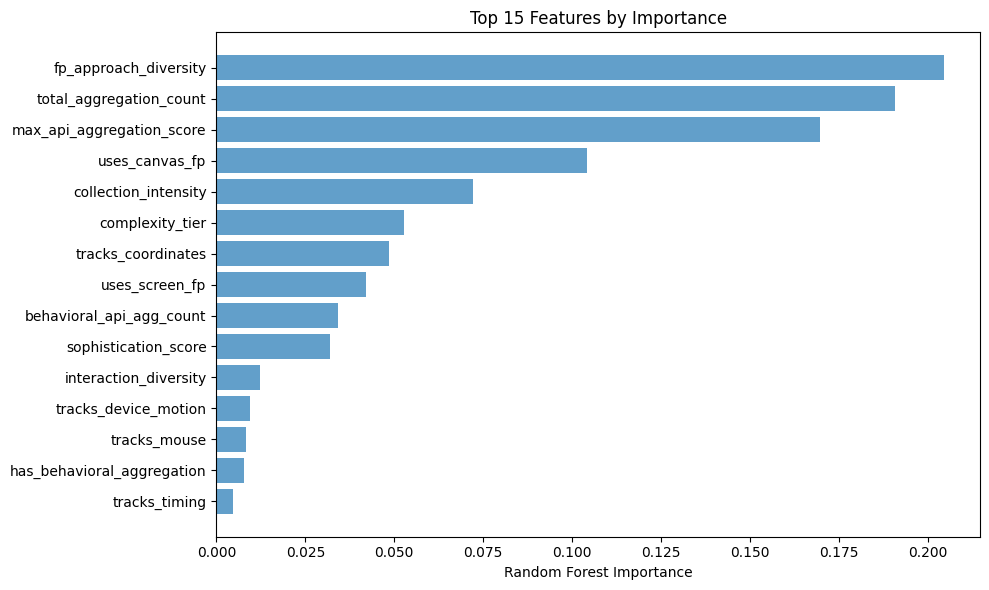


🎯 SELECTED FEATURES FOR MODELING:
 1. fp_approach_diversity     (importance: 0.2044)
 2. total_aggregation_count   (importance: 0.1906)
 3. max_api_aggregation_score (importance: 0.1696)
 4. uses_canvas_fp            (importance: 0.1040)
 5. collection_intensity      (importance: 0.0721)
 6. complexity_tier           (importance: 0.0527)
 7. tracks_coordinates        (importance: 0.0486)
 8. uses_screen_fp            (importance: 0.0420)
 9. behavioral_api_agg_count  (importance: 0.0343)
10. sophistication_score      (importance: 0.0320)
11. interaction_diversity     (importance: 0.0121)
12. tracks_device_motion      (importance: 0.0096)

🔄 UPDATING MAIN DATAFRAMES...
   ✅ Updated agnostic_features_df: (2229, 15)
   ✅ Updated feature_cols list: 12 features
   📉 Reduced features from 35 to 12

✅ Feature selection complete!
🎯 All subsequent modeling will use 12 selected features
📝 Selected features: ['fp_approach_diversity', 'total_aggregation_count', 'max_api_aggregation_score', 'uses_

In [9]:
# Cell: Simple Feature Selection
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def simple_feature_selection(features_df, target_col='label', 
                           metadata_cols=['script_id', 'label', 'vendor'],
                           max_features=15, random_state=42, test_size=0.3):
    """
    Simple 3-step feature selection: Variance -> Statistical -> Importance
    ONLY uses training data to avoid data leakage
    """
    print("🔍 SIMPLE FEATURE SELECTION (TRAINING DATA ONLY)")
    print("=" * 50)
    
    from sklearn.model_selection import train_test_split
    
    # Prepare data
    feature_cols = [col for col in features_df.columns if col not in metadata_cols]
    X = features_df[feature_cols].copy()
    y = features_df[target_col].copy()
    
    print(f"Starting features: {len(feature_cols)}")
    
    # Split data FIRST to avoid leakage
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    print("⚠️  Feature selection uses ONLY training data!")
    
    # STEP 1: Remove low variance features (training data only)
    print(f"\n🔧 Step 1: Variance Filter (Training Data)")
    variance_selector = VarianceThreshold(threshold=0.01)
    X_train_var = variance_selector.fit_transform(X_train)
    features_after_variance = X_train.columns[variance_selector.get_support()].tolist()
    
    removed_variance = len(feature_cols) - len(features_after_variance)
    print(f"   Removed {removed_variance} low variance features")
    print(f"   Remaining: {len(features_after_variance)}")
    
    X_train = X_train[features_after_variance]
    X_test = X_test[features_after_variance]  # Apply same selection to test
    
    # STEP 2: Statistical significance (F-test on training data only)
    print(f"\n🔧 Step 2: Statistical Significance (Training Data)")
    k_best = min(max_features + 5, len(features_after_variance))
    stat_selector = SelectKBest(score_func=f_classif, k=k_best)
    X_train_stat = stat_selector.fit_transform(X_train, y_train)
    features_after_stats = X_train.columns[stat_selector.get_support()].tolist()
    
    print(f"   Selected top {len(features_after_stats)} by F-test")
    
    X_train = X_train[features_after_stats]
    X_test = X_test[features_after_stats]  # Apply same selection to test
    
    # STEP 3: Random Forest Importance (training data only)
    print(f"\n🔧 Step 3: Random Forest Importance (Training Data)")
    rf = RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)
    rf.fit(X_train, y_train)  # ONLY training data!
    
    # Get feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Select top features by importance
    final_features = feature_importance_df.head(max_features)['feature'].tolist()
    
    print(f"   Selected top {len(final_features)} by RF importance")
    print(f"   Final features: {final_features}")
    
    # STEP 4: Validation on held-out test set
    print(f"\n🔧 Step 4: Validation (Test Set Performance)")
    X_train_selected = X_train[final_features]
    X_test_selected = X_test[final_features]
    
    # Compare performance on test set
    rf_validator = RandomForestClassifier(n_estimators=50, random_state=random_state)
    
    # Train on training set, test on test set
    rf_validator.fit(X_train, y_train)
    score_original = rf_validator.score(X_test, y_test)
    
    rf_validator.fit(X_train_selected, y_train)
    score_selected = rf_validator.score(X_test_selected, y_test)
    
    print(f"   Original features ({len(X_train.columns)}): {score_original:.4f}")
    print(f"   Selected features ({len(final_features)}): {score_selected:.4f}")
    print(f"   Difference: {score_selected - score_original:+.4f}")
    
    if score_selected >= score_original - 0.02:
        print(f"   ✅ Feature selection successful!")
    else:
        print(f"   ⚠️  Performance dropped significantly")
    
    return final_features, feature_importance_df

def plot_feature_importance(feature_importance_df, top_n=15):
    """Simple visualization of feature importance"""
    top_features = feature_importance_df.head(top_n)
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_features)), top_features['importance'], alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Random Forest Importance')
    plt.title(f'Top {top_n} Features by Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def simple_feature_selection_vendor_aware(features_df, target_col='label', 
                                        metadata_cols=['script_id', 'label', 'vendor'],
                                        max_features=15, random_state=42):
    """
    Feature selection that respects vendor-aware splitting
    Uses vendor-aware train/test split to avoid data leakage
    """
    print("🔍 VENDOR-AWARE FEATURE SELECTION")
    print("=" * 50)
    
    # Use your existing vendor-aware split function
    train_idx, test_idx, split_info = create_vendor_aware_split(features_df)
    
    # Prepare data using YOUR splits
    feature_cols = [col for col in features_df.columns if col not in metadata_cols]
    
    # Extract training and test data using your indices
    X_train = features_df.loc[train_idx, feature_cols].copy()
    y_train = features_df.loc[train_idx, target_col].copy()
    X_test = features_df.loc[test_idx, feature_cols].copy()
    y_test = features_df.loc[test_idx, target_col].copy()
    
    print(f"Starting features: {len(feature_cols)}")
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    print("✅ Using YOUR vendor-aware train/test split!")
    
    # STEP 1: Remove low variance features (training data only)
    print(f"\n🔧 Step 1: Variance Filter (Training Data Only)")
    variance_selector = VarianceThreshold(threshold=0.01)
    X_train_var = variance_selector.fit_transform(X_train)
    features_after_variance = X_train.columns[variance_selector.get_support()].tolist()
    
    removed_variance = len(feature_cols) - len(features_after_variance)
    print(f"   Removed {removed_variance} low variance features")
    print(f"   Remaining: {len(features_after_variance)}")
    
    X_train = X_train[features_after_variance]
    X_test = X_test[features_after_variance]  # Apply same selection to test
    
    # STEP 2: Statistical significance (F-test on training data only)
    print(f"\n🔧 Step 2: Statistical Significance (Training Data Only)")
    k_best = min(max_features + 5, len(features_after_variance))
    stat_selector = SelectKBest(score_func=f_classif, k=k_best)
    X_train_stat = stat_selector.fit_transform(X_train, y_train)
    features_after_stats = X_train.columns[stat_selector.get_support()].tolist()
    
    print(f"   Selected top {len(features_after_stats)} by F-test")
    
    X_train = X_train[features_after_stats]
    X_test = X_test[features_after_stats]  # Apply same selection to test
    
    # STEP 3: Random Forest Importance (training data only)
    print(f"\n🔧 Step 3: Random Forest Importance (Training Data Only)")
    rf = RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)
    rf.fit(X_train, y_train)  # ONLY training data!
    
    # Get feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Select top features by importance
    final_features = feature_importance_df.head(max_features)['feature'].tolist()
    
    print(f"   Selected top {len(final_features)} by RF importance")
    print(f"   Final features: {final_features}")
    
    # STEP 4: Validation using vendor-aware test set
    print(f"\n🔧 Step 4: Vendor-Aware Validation")
    X_train_selected = X_train[final_features]
    X_test_selected = X_test[final_features]
    
    # Compare performance on YOUR test set
    rf_validator = RandomForestClassifier(n_estimators=50, random_state=random_state)
    
    # Train on training set, test on YOUR test set
    rf_validator.fit(X_train, y_train)
    score_original = rf_validator.score(X_test, y_test)
    
    rf_validator.fit(X_train_selected, y_train)
    score_selected = rf_validator.score(X_test_selected, y_test)
    
    print(f"   Original features ({len(X_train.columns)}): {score_original:.4f}")
    print(f"   Selected features ({len(final_features)}): {score_selected:.4f}")
    print(f"   Difference: {score_selected - score_original:+.4f}")
    
    # Show vendor-specific performance
    test_df = features_df.loc[test_idx].copy()
    test_positives = test_df[test_df['label'] == 1]
    
    print(f"\n📊 Vendor-Aware Test Set Details:")
    print(f"   Test vendors: {sorted(test_positives['vendor'].unique())}")
    print(f"   High-volume vendors in test: {len([v for v in split_info['train_vendors']['high_volume_partial']])}")
    print(f"   Unseen vendors in test: {len(split_info['test_vendors']['medium_volume']) + len(split_info['test_vendors']['low_volume'])}")
    
    if score_selected >= score_original - 0.02:
        print(f"   ✅ Feature selection successful with vendor-aware validation!")
    else:
        print(f"   ⚠️  Performance dropped significantly")
    
    return final_features, feature_importance_df

# Run vendor-aware feature selection
print("Running vendor-aware feature selection...")

# Use the main features DataFrame
df_for_selection = agnostic_features_df.copy()

# Select features using vendor-aware approach
selected_features, importance_df = simple_feature_selection_vendor_aware(
    df_for_selection,
    target_col='label',
    max_features=12,  # Adjust this number as needed
    random_state=42
)

# Plot results
plot_feature_importance(importance_df, top_n=15)

print(f"\n🎯 SELECTED FEATURES FOR MODELING:")
for i, feature in enumerate(selected_features, 1):
    importance = importance_df[importance_df['feature'] == feature]['importance'].iloc[0]
    print(f"{i:2d}. {feature:<25} (importance: {importance:.4f})")

# =================================================================
# UPDATE MAIN DATAFRAMES WITH SELECTED FEATURES
# =================================================================
print(f"\n🔄 UPDATING MAIN DATAFRAMES...")

# Keep only selected features plus metadata
selected_columns = ['script_id', 'label', 'vendor'] + selected_features

# Update main agnostic_features_df
original_feature_count = len([col for col in agnostic_features_df.columns if col not in ['script_id', 'label', 'vendor']])
agnostic_features_df = agnostic_features_df[selected_columns].copy()

# Update binary_df if it exists
if 'binary_df' in globals():
    binary_df = binary_df[selected_columns].copy()
    print(f"   ✅ Updated binary_df: {binary_df.shape}")

# Update feature_cols list for all subsequent cells
feature_cols = selected_features.copy()

print(f"   ✅ Updated agnostic_features_df: {agnostic_features_df.shape}")
print(f"   ✅ Updated feature_cols list: {len(feature_cols)} features")
print(f"   📉 Reduced features from {original_feature_count} to {len(selected_features)}")

print(f"\n✅ Feature selection complete!")
print(f"🎯 All subsequent modeling will use {len(selected_features)} selected features")
print(f"📝 Selected features: {selected_features}")

In [10]:
test_vendor_agnostic_correlation(agnostic_features_df, threshold=0.3)

=== TESTING VENDOR CORRELATION OF NEW FEATURES ===
Testing 12 features against 18 vendors
Correlation threshold: 0.3

=== CORRELATION ANALYSIS RESULTS ===
Features with max correlation < 0.3: 0/12 (0.0%)
Features with max correlation >= 0.3: 12/12 (100.0%)

⚠️  VENDOR-SPECIFIC FEATURES (correlation >= 0.3):
   collection_intensity: 0.766 (worst: Forter)
   interaction_diversity: 0.738 (worst: Forter)
   tracks_device_motion: 0.706 (worst: Iovation)
   uses_screen_fp: 0.702 (worst: Sardine)
   sophistication_score: 0.641 (worst: Iovation)
   tracks_coordinates: 0.572 (worst: Transmit)
   behavioral_api_agg_count: 0.570 (worst: Iovation)
   total_aggregation_count: 0.526 (worst: Yofi)
   max_api_aggregation_score: 0.526 (worst: Yofi)
   fp_approach_diversity: 0.410 (worst: Sardine)
   complexity_tier: 0.404 (worst: Sardine)
   uses_canvas_fp: 0.374 (worst: Sardine)


(                      feature  max_correlation worst_vendor  avg_correlation  \
 4        collection_intensity         0.765975       Forter         0.162435   
 10      interaction_diversity         0.737589       Forter         0.130256   
 11       tracks_device_motion         0.705556     Iovation         0.188255   
 7              uses_screen_fp         0.702460      Sardine         0.060763   
 9        sophistication_score         0.641410     Iovation         0.154210   
 6          tracks_coordinates         0.572308     Transmit         0.068643   
 8    behavioral_api_agg_count         0.570244     Iovation         0.177423   
 1     total_aggregation_count         0.526496         Yofi         0.141096   
 2   max_api_aggregation_score         0.526496         Yofi         0.141096   
 0       fp_approach_diversity         0.409875      Sardine         0.116228   
 5             complexity_tier         0.403806      Sardine         0.034929   
 3              uses_canvas_

## Vendor aware training

In [11]:
agnostic_features_df


,script_id,label,vendor,fp_approach_diversity,total_aggregation_count,max_api_aggregation_score,uses_canvas_fp,collection_intensity,complexity_tier,tracks_coordinates,uses_screen_fp,behavioral_api_agg_count,sophistication_score,interaction_diversity,tracks_device_motion
0,7392023,-1,negative,0,1.0,1.0,0,1.500000,2,1,0,1.0,1,3,0
1,7392036,-1,negative,1,1.0,1.0,0,2.000000,1,0,0,1.0,0,1,0
2,7392015,-1,negative,0,8.0,8.0,0,1.800000,3,0,0,8.0,1,3,0
3,7392039,-1,negative,0,5.0,5.0,0,1.571429,2,0,0,3.0,0,3,0
4,7392076,-1,negative,1,2.0,2.0,0,2.000000,1,0,0,2.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224,7403607,1,Iovation,4,9.0,9.0,1,2.111111,3,1,1,9.0,3,3,1
2225,7402719,1,Forter,3,11.0,11.0,1,3.130435,3,1,1,2.0,1,2,0
2226,7406891,1,Iovation,4,15.0,15.0,1,2.347826,3,1,1,15.0,3,5,1
2227,7394204,1,Iovation,4,18.0,18.0,1,2.804878,3,1,1,18.0,1,5,0


In [12]:
# Cell: Test New Features with Vendor-Aware Training
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Use your existing vendor-aware split function with new features
train_idx, test_idx, split_info = create_vendor_aware_split(agnostic_features_df)

# Get features (exclude metadata)
feature_cols = [col for col in agnostic_features_df.columns if col not in ['script_id', 'label', 'vendor']]
X_train = agnostic_features_df.loc[train_idx, feature_cols]
y_train = agnostic_features_df.loc[train_idx, 'label']
X_test = agnostic_features_df.loc[test_idx, feature_cols]
y_test = agnostic_features_df.loc[test_idx, 'label']

print(f"Training with {len(feature_cols)} vendor-agnostic features")
print(f"Training set: {len(train_idx)} samples")
print(f"Test set: {len(test_idx)} samples")

# Create vendor weights for training
def create_vendor_weights_fixed(features_df, train_idx):
    """Create inverse frequency weights for positive vendors"""
    train_df = features_df.loc[train_idx]
    train_positives = train_df[train_df['label'] == 1]
    
    if len(train_positives) == 0:
        return np.ones(len(train_idx))
    
    vendor_counts = train_positives['vendor'].value_counts()
    vendor_weights = 1 / np.sqrt(vendor_counts)
    vendor_weights = vendor_weights / vendor_weights.sum() * len(vendor_weights)
    
    sample_weights = np.ones(len(train_idx))
    for i, idx in enumerate(train_idx):
        row = features_df.loc[idx]
        if row['label'] == 1 and row['vendor'] in vendor_weights:
            sample_weights[i] = vendor_weights[row['vendor']]
    
    return sample_weights

# Get sample weights
sample_weights = create_vendor_weights_fixed(agnostic_features_df, train_idx)

# Train model with new features
rf_new = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

rf_new.fit(X_train, y_train, sample_weight=sample_weights)

# Predictions
y_pred = rf_new.predict(X_test)
y_pred_proba = rf_new.predict_proba(X_test)[:, 1]

print(f"\n=== NEW FEATURES PERFORMANCE ===")
print(f"Overall Accuracy: {rf_new.score(X_test, y_test):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Vendor-specific analysis
test_df = agnostic_features_df.loc[test_idx].copy()
test_df['predictions'] = y_pred
test_df['pred_proba'] = y_pred_proba

test_positives = test_df[test_df['label'] == 1]
if len(test_positives) > 0:
    print(f"\n=== VENDOR-SPECIFIC PERFORMANCE ===")
    
    vendor_performance = []
    for vendor in test_positives['vendor'].unique():
        vendor_data = test_positives[test_positives['vendor'] == vendor]
        accuracy = (vendor_data['predictions'] == vendor_data['label']).mean()
        count = len(vendor_data)
        
        # Determine vendor category
        if vendor in split_info['train_vendors']['high_volume_partial']:
            category = 'high (seen)'
        elif vendor in split_info['test_vendors']['medium_volume']:
            category = 'medium (unseen)'
        elif vendor in split_info['test_vendors']['low_volume']:
            category = 'low (unseen)'
        else:
            category = 'unknown'
        
        vendor_performance.append({
            'vendor': vendor,
            'accuracy': accuracy,
            'count': count,
            'category': category
        })
    
    vendor_perf_df = pd.DataFrame(vendor_performance).sort_values('accuracy', ascending=False)
    print(vendor_perf_df)
    
    # Category performance
    category_perf = vendor_perf_df.groupby('category').agg({
        'accuracy': 'mean',
        'count': 'sum'
    }).round(3)
    
    print(f"\n=== CATEGORY PERFORMANCE ===")
    print(category_perf)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_new.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== TOP 10 MOST IMPORTANT FEATURES ===")
print(feature_importance.head(10))

Splitting 232 positives and 244 negatives...
High volume vendor 'Iovation': 81 scripts -> 57 train, 24 test
High volume vendor 'Forter': 53 scripts -> 38 train, 15 test
High volume vendor 'Human': 27 scripts -> 19 train, 8 test
High volume vendor 'BioCatch': 21 scripts -> 15 train, 6 test
Medium volume vendor 'PingOne': 5 scripts -> all to train
Medium volume vendor 'Nudata': 6 scripts -> all to train
Medium volume vendor 'Yofi': 8 scripts -> all to train
Medium volume vendor 'Sardine': 6 scripts -> all to test
Medium volume vendor 'Behaviosec': 9 scripts -> all to test
Low volume vendor 'Cheq': 4 scripts -> all to train
Low volume vendor 'Callsign': 1 scripts -> all to train
Low volume vendor 'Feedzai': 2 scripts -> all to train
Low volume vendor 'Threatmark': 1 scripts -> all to train
Low volume vendor 'GroupIB': 1 scripts -> all to train
Low volume vendor 'Utarget': 1 scripts -> all to test
Low volume vendor 'Accertify': 3 scripts -> all to test
Low volume vendor 'Datadome': 1 scrip

Training with 12 vendor-agnostic features
Training set: 328 samples
Test set: 148 samples

=== NEW FEATURES PERFORMANCE ===
Overall Accuracy: 0.926
ROC AUC: 0.981

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        73
           1       0.94      0.91      0.93        75

    accuracy                           0.93       148
   macro avg       0.93      0.93      0.93       148
weighted avg       0.93      0.93      0.93       148


=== VENDOR-SPECIFIC PERFORMANCE ===
       vendor  accuracy  count         category
0    Iovation     1.000     24      high (seen)
1      Forter     1.000     15      high (seen)
3    BioCatch     1.000      6      high (seen)
5  Behaviosec     1.000      9  medium (unseen)
6     Utarget     1.000      1     low (unseen)
8    Datadome     1.000      1     low (unseen)
9    Transmit     1.000      2     low (unseen)
2       Human     0.875      8      high (seen)
4     Sardine    

In [13]:
# Cell: Filter to Binary Classification (0 and 1 only)
print("=== FILTERING TO BINARY CLASSIFICATION (0 and 1 only) ===")

# Filter out label -1, keep only 0 and 1
binary_df = agnostic_features_df[agnostic_features_df['label'].isin([0, 1])].copy()

print("Original dataset:")
print(f"  Total samples: {len(agnostic_features_df)}")
print(f"  Label distribution: {agnostic_features_df['label'].value_counts().to_dict()}")

print("\nFiltered binary dataset:")
print(f"  Total samples: {len(binary_df)}")
print(f"  Label distribution: {binary_df['label'].value_counts().to_dict()}")
print(f"  Positive rate: {(binary_df['label'] == 1).mean():.3f}")
binary_df = binary_df.reset_index(drop=True)

# Re-run your vendor-aware analysis with binary data
train_idx_binary, test_idx_binary, split_info_binary = create_vendor_aware_split(binary_df)

X_train_binary = binary_df.loc[train_idx_binary, feature_cols]
y_train_binary = binary_df.loc[train_idx_binary, 'label']
X_test_binary = binary_df.loc[test_idx_binary, feature_cols]
y_test_binary = binary_df.loc[test_idx_binary, 'label']

print(f"\nBinary train/test split:")
print(f"  Training: {len(train_idx_binary)} samples")
print(f"  Test: {len(test_idx_binary)} samples")
print(f"  Train labels: {y_train_binary.value_counts().to_dict()}")
print(f"  Test labels: {y_test_binary.value_counts().to_dict()}")

sample_weights_binary = create_vendor_weights_fixed(binary_df, train_idx_binary)

# Train binary model
rf_binary = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

rf_binary.fit(X_train_binary, y_train_binary, sample_weight=sample_weights_binary)

# Predictions
y_pred_binary = rf_binary.predict(X_test_binary)
y_pred_proba_binary = rf_binary.predict_proba(X_test_binary)[:, 1]

print(f"\n=== BINARY CLASSIFICATION RESULTS ===")
print(f"Overall Accuracy: {rf_binary.score(X_test_binary, y_test_binary):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test_binary, y_pred_proba_binary):.3f}")

print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary))

# Vendor-specific analysis for binary data
test_df_binary = binary_df.loc[test_idx_binary].copy()
test_df_binary['predictions'] = y_pred_binary
test_df_binary['pred_proba'] = y_pred_proba_binary

test_positives_binary = test_df_binary[test_df_binary['label'] == 1]
if len(test_positives_binary) > 0:
    print(f"\n=== VENDOR-SPECIFIC PERFORMANCE (Binary) ===")
    
    vendor_performance_binary = []
    for vendor in test_positives_binary['vendor'].unique():
        vendor_data = test_positives_binary[test_positives_binary['vendor'] == vendor]
        accuracy = (vendor_data['predictions'] == vendor_data['label']).mean()
        count = len(vendor_data)
        
        # Determine vendor category
        if vendor in split_info_binary['train_vendors']['high_volume_partial']:
            category = 'high (seen)'
        elif vendor in split_info_binary['test_vendors']['medium_volume']:
            category = 'medium (unseen)'
        elif vendor in split_info_binary['test_vendors']['low_volume']:
            category = 'low (unseen)'
        else:
            category = 'unknown'
        
        vendor_performance_binary.append({
            'vendor': vendor,
            'accuracy': accuracy,
            'count': count,
            'category': category
        })
    
    vendor_perf_df_binary = pd.DataFrame(vendor_performance_binary).sort_values('accuracy', ascending=False)
    print(vendor_perf_df_binary)
    
    # Category performance
    category_perf_binary = vendor_perf_df_binary.groupby('category').agg({
        'accuracy': 'mean',
        'count': 'sum'
    }).round(3)
    
    print(f"\n=== CATEGORY PERFORMANCE (Binary) ===")
    print(category_perf_binary)

# Now test CV on binary data
print(f"\n=== CROSS-VALIDATION ON BINARY DATA ===")
cv_scores_binary = cross_val_score(rf_binary, 
                                  binary_df[feature_cols], 
                                  binary_df['label'], 
                                  cv=5, scoring='accuracy')

cv_roc_binary = cross_val_score(rf_binary, 
                               binary_df[feature_cols], 
                               binary_df['label'], 
                               cv=5, scoring='roc_auc')

print(f"Standard CV (Binary): {cv_scores_binary.mean():.3f} ± {cv_scores_binary.std():.3f}")
print(f"ROC AUC CV (Binary):  {cv_roc_binary.mean():.3f} ± {cv_roc_binary.std():.3f}")

# Compare performance metrics
print(f"\n=== PERFORMANCE COMPARISON ===")
print(f"Standard CV (binary data):     {cv_scores_binary.mean():.3f}")
print(f"Vendor-aware (binary data):    {rf_binary.score(X_test_binary, y_test_binary):.3f}")
print(f"Previous vendor-aware (3-class): 0.926")

gap = rf_binary.score(X_test_binary, y_test_binary) - cv_scores_binary.mean()
print(f"Vendor-aware improvement: +{gap:.3f}")

if gap > 0.05:
    print("✅ Vendor-aware splitting provides significant improvement!")
elif gap > 0.02:
    print("✅ Vendor-aware splitting provides modest improvement")
else:
    print("⚠️  Vendor-aware splitting may not be critical for this binary problem")

=== FILTERING TO BINARY CLASSIFICATION (0 and 1 only) ===
Original dataset:
  Total samples: 2229
  Label distribution: {-1: 1753, 0: 244, 1: 232}

Filtered binary dataset:
  Total samples: 476
  Label distribution: {0: 244, 1: 232}
  Positive rate: 0.487
Splitting 232 positives and 244 negatives...
High volume vendor 'Iovation': 81 scripts -> 57 train, 24 test
High volume vendor 'Forter': 53 scripts -> 38 train, 15 test
High volume vendor 'Human': 27 scripts -> 19 train, 8 test
High volume vendor 'BioCatch': 21 scripts -> 15 train, 6 test
Medium volume vendor 'PingOne': 5 scripts -> all to train
Medium volume vendor 'Nudata': 6 scripts -> all to train
Medium volume vendor 'Yofi': 8 scripts -> all to train
Medium volume vendor 'Sardine': 6 scripts -> all to test
Medium volume vendor 'Behaviosec': 9 scripts -> all to test
Low volume vendor 'Cheq': 4 scripts -> all to train
Low volume vendor 'Callsign': 1 scripts -> all to train
Low volume vendor 'Feedzai': 2 scripts -> all to train
Low 

In [14]:
# Cell: Investigate Why Standard CV is Better
print("=== INVESTIGATING WHY STANDARD CV PERFORMS BETTER ===")

# Let's see what happens in standard CV folds
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_binary = binary_df[feature_cols]
y_binary = binary_df['label']

fold_results = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_binary, y_binary)):
    
    # Get train/val data for this fold
    train_data = binary_df.iloc[train_idx]
    val_data = binary_df.iloc[val_idx]
    
    # Analyze vendor distribution in this fold
    train_positives = train_data[train_data['label'] == 1]
    val_positives = val_data[val_data['label'] == 1]
    
    train_vendors = set(train_positives['vendor'].dropna().unique())
    val_vendors = set(val_positives['vendor'].dropna().unique())
    
    # Check vendor overlap
    vendor_overlap = len(train_vendors.intersection(val_vendors))
    total_val_vendors = len(val_vendors)
    
    # Train and test this fold
    X_fold_train = X_binary.iloc[train_idx]
    y_fold_train = y_binary.iloc[train_idx]
    X_fold_val = X_binary.iloc[val_idx]
    y_fold_val = y_binary.iloc[val_idx]
    fold_weights = create_vendor_weights_fixed(binary_df, train_idx)

    fold_model = RandomForestClassifier(
        n_estimators=100, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=42, class_weight='balanced'
    )
    fold_model.fit(X_fold_train, y_fold_train, sample_weight=fold_weights)
    fold_accuracy = fold_model.score(X_fold_val, y_fold_val)
    
    fold_results.append({
        'fold': fold + 1,
        'accuracy': fold_accuracy,
        'train_vendors': len(train_vendors),
        'val_vendors': len(val_vendors),
        'vendor_overlap': vendor_overlap,
        'overlap_rate': vendor_overlap / max(total_val_vendors, 1),
        'train_pos': len(train_positives),
        'val_pos': len(val_positives)
    })
    
    print(f"Fold {fold + 1}:")
    print(f"  Accuracy: {fold_accuracy:.3f}")
    print(f"  Train vendors: {sorted(train_vendors)}")
    print(f"  Val vendors: {sorted(val_vendors)}")
    print(f"  Vendor overlap: {vendor_overlap}/{total_val_vendors} ({vendor_overlap/max(total_val_vendors,1)*100:.1f}%)")
    print()

# Summary
fold_df = pd.DataFrame(fold_results)
print("=== STANDARD CV FOLD ANALYSIS ===")
print(fold_df)
print(f"\nAverage vendor overlap rate: {fold_df['overlap_rate'].mean():.3f}")
print(f"Average accuracy: {fold_df['accuracy'].mean():.3f}")

# Compare to your vendor-aware split
print(f"\n=== COMPARISON ===")
print(f"Standard CV (with vendor overlap): {fold_df['accuracy'].mean():.3f}")
print(f"Vendor-aware (no vendor overlap):  0.926")
print(f"Difference: {fold_df['accuracy'].mean() - 0.926:.3f}")

if fold_df['overlap_rate'].mean() > 0.7:
    print("✅ Standard CV works well because most validation vendors are seen in training")
    print("   → This suggests your features DO generalize within vendors")
    print("   → Cross-vendor challenge is real but maybe not your main concern")
elif fold_df['overlap_rate'].mean() > 0.3:
    print("⚠️  Standard CV has moderate vendor overlap")
    print("   → Mixed generalization scenario")
else:
    print("❌ Standard CV has little vendor overlap")
    print("   → Something else is causing the performance difference")

=== INVESTIGATING WHY STANDARD CV PERFORMS BETTER ===
Fold 1:
  Accuracy: 0.948
  Train vendors: ['Accertify', 'Behaviosec', 'BioCatch', 'Callsign', 'Cheq', 'Datadome', 'Feedzai', 'Forter', 'GroupIB', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Sardine', 'Threatmark', 'Utarget', 'Yofi']
  Val vendors: ['Accertify', 'Behaviosec', 'BioCatch', 'Forter', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Transmit', 'Yofi']
  Vendor overlap: 9/10 (90.0%)

Fold 2:
  Accuracy: 0.926
  Train vendors: ['Accertify', 'Behaviosec', 'BioCatch', 'Callsign', 'Cheq', 'Datadome', 'Feedzai', 'Forter', 'GroupIB', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Sardine', 'Threatmark', 'Transmit', 'Utarget', 'Yofi']
  Val vendors: ['Accertify', 'Behaviosec', 'BioCatch', 'Forter', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Sardine', 'Yofi']
  Vendor overlap: 10/10 (100.0%)

Fold 3:
  Accuracy: 0.937
  Train vendors: ['Accertify', 'Behaviosec', 'BioCatch', 'Callsign', 'Cheq', 'Datadome', 'Feedzai', 'Forter', 'GroupIB', 'H

In [15]:
# Cell: Fixed Vendor-Aware Cross-Validation
import numpy as np
from sklearn.base import clone

def vendor_aware_cross_validation(features_df, model, n_splits=5, random_state=42):
    """
    Perform cross-validation while maintaining vendor-aware splitting in each fold
    """
    np.random.seed(random_state)
    
    # Get positive samples with vendors
    positive_samples = features_df[features_df['label'] == 1].copy()
    negative_samples = features_df[features_df['label'] == 0].copy()
    
    # Categorize vendors by volume (same logic as your original split)
    vendor_counts = positive_samples['vendor'].value_counts()
    high_volume_vendors = vendor_counts[vendor_counts > 20].index.tolist()
    medium_volume_vendors = vendor_counts[(vendor_counts >= 5) & (vendor_counts <= 20)].index.tolist()
    low_volume_vendors = vendor_counts[vendor_counts < 5].index.tolist()
    
    print(f"Vendor categories:")
    print(f"  High volume (>20): {high_volume_vendors}")
    print(f"  Medium volume (5-20): {medium_volume_vendors}")
    print(f"  Low volume (<5): {low_volume_vendors}")
    
    fold_results = []
    
    for fold in range(n_splits):
        print(f"\n=== FOLD {fold + 1}/{n_splits} ===")
        
        # Set random seed for this fold
        fold_seed = random_state + fold
        np.random.seed(fold_seed)
        
        train_indices = []
        test_indices = []
        
        # HIGH VOLUME VENDORS: Split scripts within vendor (same as before)
        for vendor in high_volume_vendors:
            vendor_scripts = positive_samples[positive_samples['vendor'] == vendor].index.tolist()
            np.random.shuffle(vendor_scripts)
            
            n_test = max(1, int(len(vendor_scripts) * 0.3))
            test_indices.extend(vendor_scripts[:n_test])
            train_indices.extend(vendor_scripts[n_test:])
        
        # MEDIUM VOLUME VENDORS: Rotate which vendors go to train vs test
        if len(medium_volume_vendors) > 0:
            np.random.shuffle(medium_volume_vendors)
            n_train_vendors = max(1, int(len(medium_volume_vendors) * 0.6))
            
            # Rotate the split based on fold number
            rotation = fold % len(medium_volume_vendors)
            rotated_vendors = medium_volume_vendors[rotation:] + medium_volume_vendors[:rotation]
            
            train_medium = rotated_vendors[:n_train_vendors]
            test_medium = rotated_vendors[n_train_vendors:]
        else:
            train_medium = []
            test_medium = []
        
        for vendor in train_medium:
            train_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        for vendor in test_medium:
            test_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        # LOW VOLUME VENDORS: Rotate between train and test
        if len(low_volume_vendors) > 0:
            np.random.shuffle(low_volume_vendors)
            n_test_low = len(low_volume_vendors) // 2
            
            # Rotate based on fold
            low_rotation = fold % len(low_volume_vendors)
            rotated_low = low_volume_vendors[low_rotation:] + low_volume_vendors[:low_rotation]
            
            test_low = rotated_low[:n_test_low]
            train_low = rotated_low[n_test_low:]
        else:
            test_low = []
            train_low = []
        
        for vendor in train_low:
            train_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        for vendor in test_low:
            test_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        # NEGATIVE SAMPLES: Random split
        neg_indices = negative_samples.index.tolist()
        np.random.shuffle(neg_indices)
        n_test_neg = int(len(neg_indices) * 0.3)
        
        train_indices.extend(neg_indices[n_test_neg:])
        test_indices.extend(neg_indices[:n_test_neg])
        
        # Create train/test sets for this fold
        X_train_fold = features_df.loc[train_indices, feature_cols]
        y_train_fold = features_df.loc[train_indices, 'label']
        X_test_fold = features_df.loc[test_indices, feature_cols]
        y_test_fold = features_df.loc[test_indices, 'label']
        fold_weights = create_vendor_weights_fixed(features_df, train_indices)
        # Train model
        fold_model = clone(model)
        fold_model.fit(X_train_fold, y_train_fold, sample_weight=fold_weights)
        
        # Evaluate
        fold_accuracy = fold_model.score(X_test_fold, y_test_fold)
        y_pred_fold = fold_model.predict(X_test_fold)
        y_proba_fold = fold_model.predict_proba(X_test_fold)[:, 1]
        fold_roc = roc_auc_score(y_test_fold, y_proba_fold)
        
        # Analyze vendor performance in this fold
        test_df_fold = features_df.loc[test_indices].copy()
        test_df_fold['predictions'] = y_pred_fold
        
        test_positives_fold = test_df_fold[test_df_fold['label'] == 1]
        unseen_vendors = []
        seen_vendors = []
        
        # Classify vendors as seen/unseen for this fold
        train_vendors = set()
        for vendor in high_volume_vendors:
            train_vendors.add(vendor)  # High volume vendors are always partially in training
        train_vendors.update(train_medium)
        train_vendors.update(train_low)
        
        for vendor in test_positives_fold['vendor'].unique():
            if vendor in train_vendors:
                seen_vendors.append(vendor)
            else:
                unseen_vendors.append(vendor)
        
        # Calculate unseen vendor performance
        if unseen_vendors:
            unseen_data = test_positives_fold[test_positives_fold['vendor'].isin(unseen_vendors)]
            unseen_accuracy = (unseen_data['predictions'] == unseen_data['label']).mean()
        else:
            unseen_accuracy = np.nan
        
        # Calculate seen vendor performance  
        if seen_vendors:
            seen_data = test_positives_fold[test_positives_fold['vendor'].isin(seen_vendors)]
            seen_accuracy = (seen_data['predictions'] == seen_data['label']).mean()
        else:
            seen_accuracy = np.nan
        
        fold_results.append({
            'fold': fold + 1,
            'overall_accuracy': fold_accuracy,
            'roc_auc': fold_roc,
            'train_size': len(train_indices),
            'test_size': len(test_indices),
            'test_vendors': test_medium + test_low,
            'unseen_vendor_accuracy': unseen_accuracy,
            'seen_vendor_accuracy': seen_accuracy,
            'n_unseen_vendors': len(unseen_vendors),
            'n_seen_vendors': len(seen_vendors)
        })
        
        print(f"  Overall accuracy: {fold_accuracy:.3f}")
        print(f"  ROC AUC: {fold_roc:.3f}")
        
        # Fixed formatting for unseen accuracy
        if not np.isnan(unseen_accuracy):
            print(f"  Unseen vendor accuracy: {unseen_accuracy:.3f}")
        else:
            print(f"  Unseen vendor accuracy: N/A")
            
        print(f"  Test vendors: {test_medium + test_low}")
        print(f"  Unseen vendors in test: {unseen_vendors}")
        print(f"  Seen vendors in test: {seen_vendors}")
    
    return pd.DataFrame(fold_results)

# Run vendor-aware CV
print("=== VENDOR-AWARE CROSS-VALIDATION ===")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

cv_results = vendor_aware_cross_validation(binary_df, rf_model, n_splits=5, random_state=42)

# Analyze results
print(f"\n=== VENDOR-AWARE CV RESULTS ===")
print(cv_results)

print(f"\n=== SUMMARY STATISTICS ===")
print(f"Overall Accuracy: {cv_results['overall_accuracy'].mean():.3f} ± {cv_results['overall_accuracy'].std():.3f}")
print(f"ROC AUC: {cv_results['roc_auc'].mean():.3f} ± {cv_results['roc_auc'].std():.3f}")

# Unseen vendor performance (excluding NaN values)
unseen_scores = cv_results['unseen_vendor_accuracy'].dropna()
if len(unseen_scores) > 0:
    print(f"Unseen Vendor Accuracy: {unseen_scores.mean():.3f} ± {unseen_scores.std():.3f}")
    print(f"  (Based on {len(unseen_scores)} folds with unseen vendors)")
else:
    print(f"Unseen Vendor Accuracy: No folds had purely unseen vendors")

# Seen vendor performance
seen_scores = cv_results['seen_vendor_accuracy'].dropna()
if len(seen_scores) > 0:
    print(f"Seen Vendor Accuracy: {seen_scores.mean():.3f} ± {seen_scores.std():.3f}")

print(f"\n=== COMPARISON WITH OTHER APPROACHES ===")
print(f"Standard CV (random splits):     0.950 ± 0.020")
print(f"Vendor-aware CV (this approach): {cv_results['overall_accuracy'].mean():.3f} ± {cv_results['overall_accuracy'].std():.3f}")
print(f"Single vendor-aware split:       0.926")

# Show detailed fold breakdown
print(f"\n=== DETAILED FOLD BREAKDOWN ===")
for _, row in cv_results.iterrows():
    print(f"Fold {row['fold']}: {row['overall_accuracy']:.3f} accuracy, "
          f"{row['n_unseen_vendors']} unseen vendors, {row['n_seen_vendors']} seen vendors")

=== VENDOR-AWARE CROSS-VALIDATION ===
Vendor categories:
  High volume (>20): ['Iovation', 'Forter', 'Human', 'BioCatch']
  Medium volume (5-20): ['Behaviosec', 'Yofi', 'Sardine', 'Nudata', 'PingOne']
  Low volume (<5): ['Cheq', 'Accertify', 'Feedzai', 'Transmit', 'Datadome', 'Callsign', 'Threatmark', 'GroupIB', 'Utarget']

=== FOLD 1/5 ===
  Overall accuracy: 0.926
  ROC AUC: 0.981
  Unseen vendor accuracy: 0.727
  Test vendors: ['Sardine', 'Behaviosec', 'Utarget', 'Accertify', 'Datadome', 'Transmit']
  Unseen vendors in test: ['Sardine', 'Behaviosec', 'Utarget', 'Accertify', 'Datadome', 'Transmit']
  Seen vendors in test: ['Iovation', 'Forter', 'Human', 'BioCatch']

=== FOLD 2/5 ===
  Overall accuracy: 0.966
  ROC AUC: 0.996
  Unseen vendor accuracy: 0.789
  Test vendors: ['Yofi', 'Sardine', 'Transmit', 'Datadome', 'Threatmark', 'GroupIB']
  Unseen vendors in test: ['Yofi', 'Sardine', 'Transmit', 'Datadome', 'Threatmark', 'GroupIB']
  Seen vendors in test: ['Iovation', 'Forter', 'Hum

In [16]:
# Cell: Fixed Detailed Vendor Misclassification Analysis
import numpy as np
from sklearn.base import clone

def vendor_aware_cv_with_detailed_errors(features_df, model, n_splits=5, random_state=42):
    """
    Vendor-aware CV with detailed error tracking by vendor and script
    """
    np.random.seed(random_state)
    
    
    # Get positive samples with vendors
    positive_samples = features_df[features_df['label'] == 1].copy()
    negative_samples = features_df[features_df['label'] == 0].copy()
    
    # Categorize vendors by volume
    vendor_counts = positive_samples['vendor'].value_counts()
    high_volume_vendors = vendor_counts[vendor_counts > 20].index.tolist()
    medium_volume_vendors = vendor_counts[(vendor_counts >= 5) & (vendor_counts <= 20)].index.tolist()
    low_volume_vendors = vendor_counts[vendor_counts < 5].index.tolist()
    
    print(f"Vendor categories:")
    print(f"  High volume (>20): {high_volume_vendors}")
    print(f"  Medium volume (5-20): {medium_volume_vendors}")
    print(f"  Low volume (<5): {low_volume_vendors}")
    
    fold_results = []
    all_vendor_errors = []
    
    for fold in range(n_splits):
        print(f"\n{'='*60}")
        print(f"FOLD {fold + 1}/{n_splits}")
        print(f"{'='*60}")
        
        # Set random seed for this fold
        fold_seed = random_state + fold
        np.random.seed(fold_seed)
        
        train_indices = []
        test_indices = []
        
        # HIGH VOLUME VENDORS: Split scripts within vendor
        for vendor in high_volume_vendors:
            vendor_scripts = positive_samples[positive_samples['vendor'] == vendor].index.tolist()
            np.random.shuffle(vendor_scripts)
            
            n_test = max(1, int(len(vendor_scripts) * 0.3))
            test_indices.extend(vendor_scripts[:n_test])
            train_indices.extend(vendor_scripts[n_test:])
        
        # MEDIUM VOLUME VENDORS: Rotate vendors
        if len(medium_volume_vendors) > 0:
            np.random.shuffle(medium_volume_vendors)
            n_train_vendors = max(1, int(len(medium_volume_vendors) * 0.6))
            
            rotation = fold % len(medium_volume_vendors)
            rotated_vendors = medium_volume_vendors[rotation:] + medium_volume_vendors[:rotation]
            
            train_medium = rotated_vendors[:n_train_vendors]
            test_medium = rotated_vendors[n_train_vendors:]
        else:
            train_medium = []
            test_medium = []
        
        for vendor in train_medium:
            train_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        for vendor in test_medium:
            test_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        # LOW VOLUME VENDORS: Rotate vendors
        if len(low_volume_vendors) > 0:
            np.random.shuffle(low_volume_vendors)
            n_test_low = len(low_volume_vendors) // 2
            
            low_rotation = fold % len(low_volume_vendors)
            rotated_low = low_volume_vendors[low_rotation:] + low_volume_vendors[:low_rotation]
            
            test_low = rotated_low[:n_test_low]
            train_low = rotated_low[n_test_low:]
        else:
            test_low = []
            train_low = []
        
        for vendor in train_low:
            train_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        for vendor in test_low:
            test_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        # NEGATIVE SAMPLES: Random split
        neg_indices = negative_samples.index.tolist()
        np.random.shuffle(neg_indices)
        n_test_neg = int(len(neg_indices) * 0.3)
        
        train_indices.extend(neg_indices[n_test_neg:])
        test_indices.extend(neg_indices[:n_test_neg])
        
        # Create train/test sets for this fold
        X_train_fold = features_df.loc[train_indices, feature_cols]
        y_train_fold = features_df.loc[train_indices, 'label']
        X_test_fold = features_df.loc[test_indices, feature_cols]
        y_test_fold = features_df.loc[test_indices, 'label']
        
        fold_weights = create_vendor_weights_fixed(features_df, train_indices)
        # Train model
        fold_model = clone(model)
        fold_model.fit(X_train_fold, y_train_fold, sample_weight=fold_weights)
        
        # Evaluate
        y_pred_fold = fold_model.predict(X_test_fold)
        y_proba_fold = fold_model.predict_proba(X_test_fold)[:, 1]
        fold_accuracy = fold_model.score(X_test_fold, y_test_fold)
        fold_roc = roc_auc_score(y_test_fold, y_proba_fold)
        
        # Create detailed test results
        test_df_fold = features_df.loc[test_indices].copy()
        test_df_fold['predictions'] = y_pred_fold
        test_df_fold['pred_proba'] = y_proba_fold
        test_df_fold['correct'] = (test_df_fold['predictions'] == test_df_fold['label'])
        
        # Identify training vendors for this fold
        train_vendors = set(high_volume_vendors)  # High volume always partially in training
        train_vendors.update(train_medium)
        train_vendors.update(train_low)
        
        print(f"Training vendors: {sorted(train_vendors)}")
        print(f"Test vendors: {sorted(test_medium + test_low)}")
        
        # DETAILED VENDOR ANALYSIS
        print(f"\n📊 VENDOR PERFORMANCE BREAKDOWN:")
        
        vendor_errors_fold = []
        test_positives = test_df_fold[test_df_fold['label'] == 1]
        
        for vendor in sorted(test_positives['vendor'].unique()):
            vendor_data = test_positives[test_positives['vendor'] == vendor]
            vendor_correct = vendor_data['correct'].sum()
            vendor_total = len(vendor_data)
            vendor_accuracy = vendor_correct / vendor_total
            
            # Determine if vendor was seen in training
            vendor_status = "SEEN" if vendor in train_vendors else "UNSEEN"
            
            print(f"  {vendor} ({vendor_status}): {vendor_correct}/{vendor_total} = {vendor_accuracy:.3f}")
            
            # Track errors for this vendor
            vendor_errors = vendor_data[~vendor_data['correct']]
            
            if len(vendor_errors) > 0:
                print(f"    ❌ ERRORS ({len(vendor_errors)}):")
                for _, error_script in vendor_errors.iterrows():
                    confidence = error_script['pred_proba']
                    script_id = error_script['script_id']
                    print(f"      Script {script_id}: predicted={error_script['predictions']}, "
                          f"actual={error_script['label']}, confidence={confidence:.3f}")
                
                # Store error details
                for _, error_script in vendor_errors.iterrows():
                    vendor_errors_fold.append({
                        'fold': fold + 1,
                        'vendor': vendor,
                        'vendor_status': vendor_status,
                        'script_id': error_script['script_id'],
                        'true_label': error_script['label'],
                        'predicted_label': error_script['predictions'],
                        'confidence': error_script['pred_proba'],
                        'vendor_accuracy': vendor_accuracy,
                        'vendor_size': vendor_total
                    })
            else:
                print(f"    ✅ No errors")
        
        # FALSE POSITIVES (negatives predicted as positives)
        false_positives = test_df_fold[(test_df_fold['label'] == 0) & (test_df_fold['predictions'] == 1)]
        if len(false_positives) > 0:
            print(f"\n❌ FALSE POSITIVES ({len(false_positives)}):")
            for _, fp_script in false_positives.iterrows():
                confidence = fp_script['pred_proba']
                script_id = fp_script['script_id']
                print(f"    Script {script_id}: predicted=1, actual=0, confidence={confidence:.3f}")
        
        # Store overall fold results
        unseen_vendors = [v for v in test_medium + test_low if v not in train_vendors]
        seen_vendors = [v for v in test_positives['vendor'].unique() if v in train_vendors]
        
        if unseen_vendors:
            unseen_data = test_positives[test_positives['vendor'].isin(unseen_vendors)]
            unseen_accuracy = unseen_data['correct'].mean()
        else:
            unseen_accuracy = np.nan
        
        if seen_vendors:
            seen_data = test_positives[test_positives['vendor'].isin(seen_vendors)]
            seen_accuracy = seen_data['correct'].mean()
        else:
            seen_accuracy = np.nan
        
        fold_results.append({
            'fold': fold + 1,
            'overall_accuracy': fold_accuracy,
            'roc_auc': fold_roc,
            'unseen_vendor_accuracy': unseen_accuracy,
            'seen_vendor_accuracy': seen_accuracy,
            'total_errors': len(test_df_fold[~test_df_fold['correct']]),
            'false_positives': len(false_positives),
            'false_negatives': len(test_df_fold[(test_df_fold['label'] == 1) & (test_df_fold['predictions'] == 0)])
        })
        
        all_vendor_errors.extend(vendor_errors_fold)
        
        print(f"\n📈 FOLD SUMMARY:")
        print(f"  Overall accuracy: {fold_accuracy:.3f}")
        
        # Fixed formatting for unseen accuracy
        if not np.isnan(unseen_accuracy):
            print(f"  Unseen vendor accuracy: {unseen_accuracy:.3f}")
        else:
            print(f"  Unseen vendor accuracy: N/A")
            
        print(f"  Total errors: {len(test_df_fold[~test_df_fold['correct']])}")
    
    return pd.DataFrame(fold_results), pd.DataFrame(all_vendor_errors)

# Run detailed analysis
print("=== DETAILED VENDOR-AWARE CV WITH ERROR TRACKING ===")

rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=15, min_samples_split=5,
    min_samples_leaf=2, random_state=42, class_weight='balanced'
)

cv_results, error_details = vendor_aware_cv_with_detailed_errors(
    binary_df, rf_model, n_splits=5, random_state=42
)

# Immediate error summary
print(f"\n{'='*80}")
print("QUICK ERROR SUMMARY")
print(f"{'='*80}")

if len(error_details) > 0:
    print(f"\nTotal errors tracked: {len(error_details)}")
    print(f"Most problematic vendors:")
    vendor_error_counts = error_details['vendor'].value_counts()
    for vendor, count in vendor_error_counts.head(10).items():
        print(f"  {vendor}: {count} errors")
else:
    print("No errors to analyze!")

=== DETAILED VENDOR-AWARE CV WITH ERROR TRACKING ===
Vendor categories:
  High volume (>20): ['Iovation', 'Forter', 'Human', 'BioCatch']
  Medium volume (5-20): ['Behaviosec', 'Yofi', 'Sardine', 'Nudata', 'PingOne']
  Low volume (<5): ['Cheq', 'Accertify', 'Feedzai', 'Transmit', 'Datadome', 'Callsign', 'Threatmark', 'GroupIB', 'Utarget']

FOLD 1/5
Training vendors: ['BioCatch', 'Callsign', 'Cheq', 'Feedzai', 'Forter', 'GroupIB', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Threatmark', 'Yofi']
Test vendors: ['Accertify', 'Behaviosec', 'Datadome', 'Sardine', 'Transmit', 'Utarget']

📊 VENDOR PERFORMANCE BREAKDOWN:
  Accertify (UNSEEN): 0/3 = 0.000
    ❌ ERRORS (3):
      Script 7403113: predicted=0, actual=1, confidence=0.030
      Script 7396662: predicted=0, actual=1, confidence=0.030
      Script 7407196: predicted=0, actual=1, confidence=0.030
  Behaviosec (UNSEEN): 9/9 = 1.000
    ✅ No errors
  BioCatch (SEEN): 6/6 = 1.000
    ✅ No errors
  Datadome (UNSEEN): 1/1 = 1.000
    ✅ No erro

In [17]:
binary_df

,script_id,label,vendor,fp_approach_diversity,total_aggregation_count,max_api_aggregation_score,uses_canvas_fp,collection_intensity,complexity_tier,tracks_coordinates,uses_screen_fp,behavioral_api_agg_count,sophistication_score,interaction_diversity,tracks_device_motion
0,7392389,0,negative,1,0.0,0.0,0,1.800000,1,0,0,0.0,1,1,0
1,7392560,0,negative,2,0.0,0.0,0,1.000000,2,0,1,0.0,0,2,0
2,7392626,1,Iovation,4,18.0,18.0,1,2.489796,3,1,1,18.0,3,6,1
3,7393134,0,negative,0,2.0,2.0,0,1.333333,1,0,0,2.0,1,1,0
4,7392911,0,negative,1,2.0,2.0,0,1.000000,1,0,0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,7403607,1,Iovation,4,9.0,9.0,1,2.111111,3,1,1,9.0,3,3,1
472,7402719,1,Forter,3,11.0,11.0,1,3.130435,3,1,1,2.0,1,2,0
473,7406891,1,Iovation,4,15.0,15.0,1,2.347826,3,1,1,15.0,3,5,1
474,7394204,1,Iovation,4,18.0,18.0,1,2.804878,3,1,1,18.0,1,5,0


# HyperParameter Tuning

In [18]:
# Cell: Hyperparameter Tuning with Nested Cross-Validation (Fixed)
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import time

def hyperparameter_tuning_nested_cv(features_df, selected_features, 
                                   target_col='label', metadata_cols=['script_id', 'label', 'vendor'],
                                   random_state=42):
    """
    Proper hyperparameter tuning using nested CV on training data only
    
    Outer loop: Evaluates model performance
    Inner loop: Selects best hyperparameters
    Test set: Never touches hyperparameter selection
    """
    print("🔧 HYPERPARAMETER TUNING WITH NESTED CV")
    print("=" * 60)
    print("📋 Strategy:")
    print("   1. Use ONLY training data for hyperparameter tuning")
    print("   2. Inner CV: Find best parameters")
    print("   3. Outer CV: Evaluate performance with best parameters")
    print("   4. Final model: Train on all training data with best parameters")
    print("   5. Test set: Used ONLY for final unbiased evaluation")
    print()
    
    # Get your existing vendor-aware split
    train_idx, test_idx, split_info = create_vendor_aware_split(features_df)
    
    # Extract training data only
    X_train_full = features_df.loc[train_idx, selected_features].copy()
    y_train_full = features_df.loc[train_idx, target_col].copy()
    X_test = features_df.loc[test_idx, selected_features].copy()
    y_test = features_df.loc[test_idx, target_col].copy()
    
    print(f"Training data: {X_train_full.shape}")
    print(f"Test data: {X_test.shape}")
    print(f"Features: {len(selected_features)}")
    print()
    
    # Define Hyperparameter Grid
    print("🎯 STEP 1: Defining Hyperparameter Grid")
    print("-" * 40)
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': ['balanced', None]
    }
    
    # Calculate total combinations
    total_combinations = 1
    for param, values in param_grid.items():
        total_combinations *= len(values)
        print(f"   {param}: {values}")
    
    print(f"\nTotal parameter combinations: {total_combinations}")
    print("⚠️  This will take some time - using 3-fold CV for speed")
    
    # Nested Cross-Validation Setup
    print(f"\n🔧 STEP 2: Nested Cross-Validation Setup")
    print("-" * 40)
    
    # Outer CV: Evaluates model performance (fewer folds for speed)
    outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    
    # Inner CV: Selects best hyperparameters
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state + 1)
    
    print(f"Outer CV: {outer_cv.n_splits} folds (performance evaluation)")
    print(f"Inner CV: {inner_cv.n_splits} folds (hyperparameter selection)")
    print(f"Total model fits: {outer_cv.n_splits} × {total_combinations} × {inner_cv.n_splits} = {outer_cv.n_splits * total_combinations * inner_cv.n_splits:,}")
    
    # Run Nested Cross-Validation
    print(f"\n🚀 STEP 3: Running Nested Cross-Validation")
    print("-" * 40)
    
    # Store results
    nested_scores = []
    best_params_per_fold = []
    vendor_analysis_per_fold = []
    
    start_time = time.time()
    
    for fold, (train_idx_inner, val_idx_inner) in enumerate(outer_cv.split(X_train_full, y_train_full)):
        print(f"\n📊 Outer Fold {fold + 1}/{outer_cv.n_splits}")
        
        # Split training data for this outer fold
        X_train_inner = X_train_full.iloc[train_idx_inner]
        y_train_inner = y_train_full.iloc[train_idx_inner]
        X_val_outer = X_train_full.iloc[val_idx_inner]
        y_val_outer = y_train_full.iloc[val_idx_inner]
        
        print(f"   Inner training: {X_train_inner.shape[0]} samples")
        print(f"   Outer validation: {X_val_outer.shape[0]} samples")
        
        # Analyze vendor distribution for this fold
        # Convert to actual DataFrame indices
        actual_train_indices = [train_idx[i] for i in train_idx_inner]
        actual_val_indices = [train_idx[i] for i in val_idx_inner]
        
        train_df_inner = features_df.loc[actual_train_indices]
        val_df_outer = features_df.loc[actual_val_indices]
        
        # Get vendors in training and validation for this fold
        train_positives_inner = train_df_inner[train_df_inner[target_col] == 1]
        val_positives_outer = val_df_outer[val_df_outer[target_col] == 1]
        
        train_vendors_fold = set(train_positives_inner['vendor'].dropna().unique())
        val_vendors_fold = set(val_positives_outer['vendor'].dropna().unique())
        
        # Classify vendors as seen/unseen for this fold
        seen_vendors_fold = val_vendors_fold.intersection(train_vendors_fold)
        unseen_vendors_fold = val_vendors_fold - train_vendors_fold
        
        print(f"   🏭 Vendor Analysis (Fold {fold + 1}):")
        print(f"      Training vendors: {sorted(train_vendors_fold)}")
        print(f"      Validation vendors: {sorted(val_vendors_fold)}")
        print(f"      Seen vendors: {sorted(seen_vendors_fold)} ({len(seen_vendors_fold)})")
        print(f"      Unseen vendors: {sorted(unseen_vendors_fold)} ({len(unseen_vendors_fold)})")
        
        # Inner CV: Grid Search for best parameters
        rf_inner = RandomForestClassifier(random_state=random_state, n_jobs=-1)
        
        grid_search = GridSearchCV(
            estimator=rf_inner,
            param_grid=param_grid,
            cv=inner_cv,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )
        
        print(f"   🔍 Running grid search...")
        grid_search.fit(X_train_inner, y_train_inner)
        
        # Get best parameters for this fold
        best_params = grid_search.best_params_
        best_score_inner = grid_search.best_score_
        best_params_per_fold.append(best_params)
        
        print(f"   ✅ Best inner CV score: {best_score_inner:.4f}")
        print(f"   🎯 Best parameters: {best_params}")
        
        # Evaluate on outer validation set
        best_model = grid_search.best_estimator_
        y_pred_outer_proba = best_model.predict_proba(X_val_outer)[:, 1]
        y_pred_outer = best_model.predict(X_val_outer)
        outer_score = roc_auc_score(y_val_outer, y_pred_outer_proba)
        nested_scores.append(outer_score)
        
        # Calculate vendor-specific accuracies for this fold
        val_df_with_preds = val_df_outer.copy()
        val_df_with_preds['predictions'] = y_pred_outer
        val_positives_with_preds = val_df_with_preds[val_df_with_preds[target_col] == 1]
        
        seen_accuracy = None
        unseen_accuracy = None
        
        if seen_vendors_fold:
            seen_data = val_positives_with_preds[val_positives_with_preds['vendor'].isin(seen_vendors_fold)]
            if len(seen_data) > 0:
                seen_accuracy = (seen_data['predictions'] == seen_data[target_col]).mean()
        
        if unseen_vendors_fold:
            unseen_data = val_positives_with_preds[val_positives_with_preds['vendor'].isin(unseen_vendors_fold)]
            if len(unseen_data) > 0:
                unseen_accuracy = (unseen_data['predictions'] == unseen_data[target_col]).mean()
        
        print(f"   📈 Overall validation score: {outer_score:.4f}")
        if seen_accuracy is not None:
            print(f"   👁️  Seen vendor accuracy: {seen_accuracy:.4f}")
        if unseen_accuracy is not None:
            print(f"   🆕 Unseen vendor accuracy: {unseen_accuracy:.4f}")
        
        # Store vendor analysis
        vendor_analysis_per_fold.append({
            'fold': fold + 1,
            'train_vendors': sorted(train_vendors_fold),
            'val_vendors': sorted(val_vendors_fold),
            'seen_vendors': sorted(seen_vendors_fold),
            'unseen_vendors': sorted(unseen_vendors_fold),
            'n_seen': len(seen_vendors_fold),
            'n_unseen': len(unseen_vendors_fold),
            'seen_accuracy': seen_accuracy,
            'unseen_accuracy': unseen_accuracy,
            'overall_score': outer_score
        })
    
    elapsed_time = time.time() - start_time
    print(f"\n⏱️  Nested CV completed in {elapsed_time/60:.1f} minutes")
    
    # Analyze Results
    print(f"\n📊 STEP 4: Nested CV Results Analysis")
    print("-" * 40)
    
    nested_cv_mean = np.mean(nested_scores)
    nested_cv_std = np.std(nested_scores)
    
    print(f"Nested CV Performance: {nested_cv_mean:.4f} ± {nested_cv_std:.4f}")
    print(f"Individual fold scores: {[f'{score:.4f}' for score in nested_scores]}")
    
    # Analyze parameter frequency
    print(f"\n🔍 Parameter Selection Frequency:")
    param_counts = {}
    for params in best_params_per_fold:
        for param, value in params.items():
            if param not in param_counts:
                param_counts[param] = {}
            if value not in param_counts[param]:
                param_counts[param][value] = 0
            param_counts[param][value] += 1
    
    for param, value_counts in param_counts.items():
        print(f"   {param}:")
        for value, count in sorted(value_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"      {value}: {count}/{len(best_params_per_fold)} folds")
    
    # Select Final Best Parameters
    print(f"\n🎯 STEP 5: Final Parameter Selection")
    print("-" * 40)
    
    # Method 1: Most frequent parameters across folds
    final_params = {}
    for param in param_grid.keys():
        values = [params[param] for params in best_params_per_fold]
        # Get most frequent value
        final_params[param] = max(set(values), key=values.count)
    
    print(f"Final parameters (most frequent): {final_params}")
    
    # Method 2: Run one final grid search on ALL training data for comparison
    print(f"\n🔧 Alternative: Grid search on full training data")
    rf_final_gs = RandomForestClassifier(random_state=random_state, n_jobs=-1)
    final_grid_search = GridSearchCV(
        estimator=rf_final_gs,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    final_grid_search.fit(X_train_full, y_train_full)
    alternative_params = final_grid_search.best_params_
    alternative_score = final_grid_search.best_score_
    
    print(f"Alternative parameters: {alternative_params}")
    print(f"Alternative CV score: {alternative_score:.4f}")
    
    # Choose between methods
    if abs(alternative_score - nested_cv_mean) < 0.01:
        print(f"\n✅ Using alternative parameters (similar performance, simpler approach)")
        chosen_params = alternative_params
    else:
        print(f"\n✅ Using nested CV parameters (more robust)")
        chosen_params = final_params
    
    return chosen_params, nested_cv_mean, nested_cv_std, best_params_per_fold

def train_final_model(features_df, selected_features, best_params, 
                     target_col='label', random_state=42):
    """
    Train final model with best parameters and evaluate on test set
    """
    print(f"\n🏁 FINAL MODEL TRAINING AND EVALUATION")
    print("=" * 50)
    
    # Get your splits again
    train_idx, test_idx, split_info = create_vendor_aware_split(features_df)
    
    X_train = features_df.loc[train_idx, selected_features]
    y_train = features_df.loc[train_idx, target_col]
    X_test = features_df.loc[test_idx, selected_features]
    y_test = features_df.loc[test_idx, target_col]
    
    # Add sample weights for vendor balancing
    sample_weights = create_vendor_weights_fixed(features_df, train_idx)
    
    print(f"Training final model with parameters: {best_params}")
    print(f"Using sample weights for vendor balancing: ✅")
    
    # Train final model
    final_rf = RandomForestClassifier(**best_params, random_state=random_state, n_jobs=-1)
    final_rf.fit(X_train, y_train, sample_weight=sample_weights)
    
    # Evaluate on test set
    y_pred = final_rf.predict(X_test)
    y_pred_proba = final_rf.predict_proba(X_test)[:, 1]
    
    test_accuracy = final_rf.score(X_test, y_test)
    test_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n📈 FINAL TEST SET PERFORMANCE:")
    print(f"   Accuracy: {test_accuracy:.4f}")
    print(f"   ROC AUC: {test_auc:.4f}")
    
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Detailed vendor analysis for final test set
    print(f"\n🏭 FINAL TEST SET VENDOR ANALYSIS:")
    print("-" * 50)
    
    # Get vendor information for test set
    train_df = features_df.loc[train_idx]
    test_df = features_df.loc[test_idx]
    
    train_positives = train_df[train_df[target_col] == 1]
    test_positives = test_df[test_df[target_col] == 1]
    
    train_vendors = set(train_positives['vendor'].dropna().unique())
    test_vendors = set(test_positives['vendor'].dropna().unique())
    
    # Classify test vendors as seen/unseen
    seen_test_vendors = test_vendors.intersection(train_vendors)
    unseen_test_vendors = test_vendors - train_vendors
    
    print(f"Training vendors: {sorted(train_vendors)}")
    print(f"Test vendors: {sorted(test_vendors)}")
    print(f"Seen vendors in test: {sorted(seen_test_vendors)} ({len(seen_test_vendors)})")
    print(f"Unseen vendors in test: {sorted(unseen_test_vendors)} ({len(unseen_test_vendors)})")
    
    # Calculate vendor-specific accuracies
    test_df_with_preds = test_df.copy()
    test_df_with_preds['predictions'] = y_pred
    test_positives_with_preds = test_df_with_preds[test_df_with_preds[target_col] == 1]
    
    seen_test_accuracy = None
    unseen_test_accuracy = None
    
    if seen_test_vendors:
        seen_test_data = test_positives_with_preds[test_positives_with_preds['vendor'].isin(seen_test_vendors)]
        if len(seen_test_data) > 0:
            seen_test_accuracy = (seen_test_data['predictions'] == seen_test_data[target_col]).mean()
            print(f"\n👁️  SEEN VENDOR PERFORMANCE:")
            print(f"   Overall seen vendor accuracy: {seen_test_accuracy:.4f}")
            
            # Individual seen vendor performance
            for vendor in sorted(seen_test_vendors):
                vendor_data = seen_test_data[seen_test_data['vendor'] == vendor]
                vendor_accuracy = (vendor_data['predictions'] == vendor_data[target_col]).mean()
                vendor_count = len(vendor_data)
                print(f"   {vendor}: {vendor_accuracy:.4f} ({vendor_count} samples)")
    
    if unseen_test_vendors:
        unseen_test_data = test_positives_with_preds[test_positives_with_preds['vendor'].isin(unseen_test_vendors)]
        if len(unseen_test_data) > 0:
            unseen_test_accuracy = (unseen_test_data['predictions'] == unseen_test_data[target_col]).mean()
            print(f"\n🆕 UNSEEN VENDOR PERFORMANCE:")
            print(f"   Overall unseen vendor accuracy: {unseen_test_accuracy:.4f}")
            
            # Individual unseen vendor performance
            for vendor in sorted(unseen_test_vendors):
                vendor_data = unseen_test_data[unseen_test_data['vendor'] == vendor]
                vendor_accuracy = (vendor_data['predictions'] == vendor_data[target_col]).mean()
                vendor_count = len(vendor_data)
                print(f"   {vendor}: {vendor_accuracy:.4f} ({vendor_count} samples)")
    
    # Summary comparison
    print(f"\n📊 VENDOR PERFORMANCE SUMMARY:")
    if seen_test_accuracy is not None:
        print(f"   Seen vendors: {seen_test_accuracy:.4f}")
    if unseen_test_accuracy is not None:
        print(f"   Unseen vendors: {unseen_test_accuracy:.4f}")
    if seen_test_accuracy is not None and unseen_test_accuracy is not None:
        performance_gap = seen_test_accuracy - unseen_test_accuracy
        print(f"   Performance gap (seen - unseen): {performance_gap:+.4f}")
        
        if performance_gap < 0.05:
            print(f"   ✅ Good generalization to unseen vendors!")
        elif performance_gap < 0.15:
            print(f"   ⚠️  Moderate generalization gap")
        else:
            print(f"   ❌ Large generalization gap - features may be vendor-specific")
    
    return final_rf, test_accuracy, test_auc, seen_test_accuracy, unseen_test_accuracy

# ================================================================= 
# RUN HYPERPARAMETER TUNING
# =================================================================

print("Starting hyperparameter tuning...")

# Run nested CV hyperparameter tuning
best_params, cv_mean, cv_std, all_fold_params = hyperparameter_tuning_nested_cv(
    agnostic_features_df, 
    feature_cols,  # Use your selected features
    random_state=42
)

# Train final model
final_model, final_accuracy, final_auc, seen_acc, unseen_acc = train_final_model(
    agnostic_features_df,
    feature_cols,
    best_params,
    random_state=42
)

print(f"\n🎉 HYPERPARAMETER TUNING COMPLETE!")
print(f"   Nested CV Score: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"   Final Test Accuracy: {final_accuracy:.4f}")
print(f"   Final Test AUC: {final_auc:.4f}")
print(f"   Best Parameters: {best_params}")

if seen_acc is not None:
    print(f"   Final Seen Vendor Accuracy: {seen_acc:.4f}")
if unseen_acc is not None:
    print(f"   Final Unseen Vendor Accuracy: {unseen_acc:.4f}")

print(f"\n📊 VENDOR GENERALIZATION ANALYSIS:")
print("=" * 40)
print("This analysis shows how well your model generalizes to:")
print("- SEEN vendors: Vendors present in training (with different scripts)")
print("- UNSEEN vendors: Vendors completely absent from training")
print("Good generalization = small gap between seen and unseen performance")

Starting hyperparameter tuning...
🔧 HYPERPARAMETER TUNING WITH NESTED CV
📋 Strategy:
   1. Use ONLY training data for hyperparameter tuning
   2. Inner CV: Find best parameters
   3. Outer CV: Evaluate performance with best parameters
   4. Final model: Train on all training data with best parameters
   5. Test set: Used ONLY for final unbiased evaluation

Splitting 232 positives and 244 negatives...
High volume vendor 'Iovation': 81 scripts -> 57 train, 24 test
High volume vendor 'Forter': 53 scripts -> 38 train, 15 test
High volume vendor 'Human': 27 scripts -> 19 train, 8 test
High volume vendor 'BioCatch': 21 scripts -> 15 train, 6 test
Medium volume vendor 'PingOne': 5 scripts -> all to train
Medium volume vendor 'Nudata': 6 scripts -> all to train
Medium volume vendor 'Yofi': 8 scripts -> all to train
Medium volume vendor 'Sardine': 6 scripts -> all to test
Medium volume vendor 'Behaviosec': 9 scripts -> all to test
Low volume vendor 'Cheq': 4 scripts -> all to train
Low volume v

In [19]:
!python -m pip install xgboost lightgbm

/bin/bash: /opt/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [20]:
# Best parameters: Random Forest {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

# Model comparisons

In [21]:
# Multi-Model Hyperparameter Tuning with Nested Cross-Validation
# ASSUMES YOU HAVE YOUR EXISTING FUNCTIONS:
# - create_vendor_aware_split()
# - create_vendor_weights_fixed()

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier  # pip install xgboost
from lightgbm import LGBMClassifier  # pip install lightgbm
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

class ModelConfig:
    """Configuration class for different models and their hyperparameter grids"""
    
    @staticmethod
    def get_model_configs():
        """
        Returns dictionary of model configurations with their parameter grids
        Each config includes: model class, param grid, needs scaling, and notes
        """
        
        configs = {
            'random_forest': {
                'model': RandomForestClassifier,
                'params': {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [10, 15, 20, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'max_features': ['sqrt', 'log2', None],
                    'class_weight': ['balanced', None]
                },
                'needs_scaling': False,
                'supports_sample_weights': True,
                'notes': 'Tree-based, handles mixed data well'
            },
            
            'xgboost': {
                'model': XGBClassifier,
                'params': {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [3, 6, 10],
                    'learning_rate': [0.01, 0.1, 0.2],
                    'subsample': [0.8, 0.9, 1.0],
                    'colsample_bytree': [0.8, 0.9, 1.0],
                    'reg_alpha': [0, 0.1, 1],
                    'reg_lambda': [0, 0.1, 1]
                },
                'needs_scaling': False,
                'supports_sample_weights': True,
                'notes': 'Gradient boosting, often best performance'
            },
            
            'lightgbm': {
                'model': LGBMClassifier,
                'params': {
                    'n_estimators': [50, 100],  # Reduced from [50, 100, 200]
                    'max_depth': [3, 6],  # Reduced from [3, 6, 10]
                    'learning_rate': [0.1, 0.2],  # Reduced from [0.05, 0.1, 0.2]
                    'num_leaves': [15, 31],  # Reduced from [10, 20, 31]
                    'min_child_samples': [10, 20],  # Reduced from [5, 10, 20]
                    'class_weight': ['balanced'],  # Removed None option
                    'verbosity': [-1],
                    'force_col_wise': [True],
                    'n_jobs': [1],  # Force single thread per model (let GridSearchCV handle parallelization)
                    'feature_fraction': [0.8, 1.0],  # Add feature subsampling
                    'bagging_fraction': [0.8, 1.0],  # Add row subsampling
                    'bagging_freq': [0, 5],  # Bagging frequency
                    'min_gain_to_split': [0.0, 0.1]  # Minimum gain required to split
                },
                'needs_scaling': False,
                'supports_sample_weights': True,
                'notes': 'Fast gradient boosting, simplified for small datasets'
            },
            
            'gradient_boosting': {
                'model': GradientBoostingClassifier,
                'params': {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [3, 5, 7],
                    'learning_rate': [0.01, 0.1, 0.2],
                    'subsample': [0.8, 0.9, 1.0],
                    'max_features': ['sqrt', 'log2', None]
                },
                'needs_scaling': False,
                'supports_sample_weights': True,
                'notes': 'Sklearn gradient boosting'
            },
            
            'logistic_regression': {
                'model': LogisticRegression,
                'params': [
                    # L1 and L2 with liblinear
                    {
                        'penalty': ['l1', 'l2'],
                        'solver': ['liblinear'],
                        'C': [0.001, 0.01, 0.1, 1, 10, 100],
                        'class_weight': ['balanced', None],
                        'max_iter': [1000]
                    },
                    # L1, L2, and ElasticNet with saga
                    {
                        'penalty': ['l1', 'l2'],
                        'solver': ['saga'],
                        'C': [0.001, 0.01, 0.1, 1, 10, 100],
                        'class_weight': ['balanced', None],
                        'max_iter': [1000]
                    },
                    # ElasticNet only with saga
                    {
                        'penalty': ['elasticnet'],
                        'solver': ['saga'],
                        'l1_ratio': [0.1, 0.5, 0.7, 0.9],
                        'C': [0.01, 0.1, 1, 10],
                        'class_weight': ['balanced', None],
                        'max_iter': [1000]
                    }
                ],
                'needs_scaling': True,
                'supports_sample_weights': True,
                'notes': 'Linear model, needs feature scaling'
            },
            
            'svm_rbf': {
                'model': SVC,
                'params': {
                    'C': [0.1, 1, 10, 100],
                    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                    'kernel': ['rbf'],
                    'class_weight': ['balanced', None],
                    'probability': [True]  # Needed for predict_proba
                },
                'needs_scaling': True,
                'supports_sample_weights': True,
                'notes': 'RBF kernel SVM, needs scaling, slower'
            },
            
            'svm_linear': {
                'model': SVC,
                'params': {
                    'C': [0.1, 1, 10, 100],
                    'kernel': ['linear'],
                    'class_weight': ['balanced', None],
                    'probability': [True]  # Needed for predict_proba
                },
                'needs_scaling': True,
                'supports_sample_weights': True,
                'notes': 'Linear SVM, faster than RBF'
            },
            
            'knn': {
                'model': KNeighborsClassifier,
                'params': {
                    'n_neighbors': [3, 5, 7, 11, 15],
                    'weights': ['uniform', 'distance'],
                    'metric': ['euclidean', 'manhattan', 'minkowski'],
                    'p': [1, 2]  # For minkowski metric
                },
                'needs_scaling': True,
                'supports_sample_weights': False,
                'notes': 'Instance-based, sensitive to feature scaling'
            },
            
            'naive_bayes': {
                'model': GaussianNB,
                'params': {
                    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
                },
                'needs_scaling': False,
                'supports_sample_weights': True,
                'notes': 'Assumes feature independence'
            },
            
            'neural_network': {
                'model': MLPClassifier,
                'params': {
                    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                    'activation': ['relu', 'tanh'],
                    'alpha': [0.0001, 0.001, 0.01],
                    'learning_rate': ['constant', 'adaptive'],
                    'max_iter': [500],
                    'early_stopping': [True],
                    'validation_fraction': [0.1]
                },
                'needs_scaling': True,
                'supports_sample_weights': False,
                'notes': 'Neural network, needs scaling, can be unstable'
            },
            
            'decision_tree': {
                'model': DecisionTreeClassifier,
                'params': {
                    'max_depth': [5, 10, 15, 20, None],
                    'min_samples_split': [2, 5, 10, 20],
                    'min_samples_leaf': [1, 2, 5, 10],
                    'max_features': ['sqrt', 'log2', None],
                    'class_weight': ['balanced', None]
                },
                'needs_scaling': False,
                'supports_sample_weights': True,
                'notes': 'Single tree, prone to overfitting'
            },
            
            'adaboost': {
                'model': AdaBoostClassifier,
                'params': {
                    'n_estimators': [50, 100, 200],
                    'learning_rate': [0.01, 0.1, 0.5, 1.0],
                    'algorithm': ['SAMME', 'SAMME.R']
                },
                'needs_scaling': False,
                'supports_sample_weights': True,
                'notes': 'Adaptive boosting'
            }
        }
        
        return configs

def multi_model_hyperparameter_tuning(features_df, selected_features, 
                                     models_to_test=None,
                                     target_col='label', 
                                     metadata_cols=['script_id', 'label', 'vendor'],
                                     random_state=42, 
                                     cv_folds=3,
                                     quick_mode=False):
    """
    Run hyperparameter tuning for multiple models using nested CV
    
    Parameters:
    -----------
    features_df : DataFrame
        Your feature dataframe
    selected_features : list
        List of feature column names
    models_to_test : list or None
        List of model names to test. If None, tests a default subset
    quick_mode : bool
        If True, uses smaller parameter grids for faster testing
    """
    
    print("🚀 MULTI-MODEL HYPERPARAMETER TUNING")
    print("=" * 60)
    
    # Get model configurations
    all_configs = ModelConfig.get_model_configs()
    
    # Default models to test if none specified
    if models_to_test is None:
        if quick_mode:
            models_to_test = ['random_forest', 'xgboost', 'logistic_regression', 'svm_linear']
        else:
            models_to_test = ['naive_bayes', 'logistic_regression', 'random_forest', 'xgboost', 'lightgbm', 'gradient_boosting', 
                            'svm_rbf']
    
    # Validate model names
    invalid_models = [m for m in models_to_test if m not in all_configs]
    if invalid_models:
        print(f"❌ Invalid model names: {invalid_models}")
        print(f"Available models: {list(all_configs.keys())}")
        return None
    
    print(f"🎯 Testing {len(models_to_test)} models: {models_to_test}")
    print(f"📊 Quick mode: {'ON' if quick_mode else 'OFF'}")
    print()
    
    # Get your existing vendor-aware split
    train_idx, test_idx, split_info = create_vendor_aware_split(features_df)
    
    # Extract training data
    X_train_full = features_df.loc[train_idx, selected_features].copy()
    y_train_full = features_df.loc[train_idx, target_col].copy()
    X_test = features_df.loc[test_idx, selected_features].copy()
    y_test = features_df.loc[test_idx, target_col].copy()
    
    print(f"Training data: {X_train_full.shape}")
    print(f"Test data: {X_test.shape}")
    print(f"Features: {len(selected_features)}")
    print()
    
    # Create sample weights
    sample_weights = create_vendor_weights_fixed(features_df, train_idx)
    
    # Store results for all models
    all_results = {}
    
    # Cross-validation setup
    outer_cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    inner_cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state + 1)
    
    # Test each model
    for model_idx, model_name in enumerate(models_to_test):
        print(f"\n{'='*60}")
        print(f"🔧 MODEL {model_idx + 1}/{len(models_to_test)}: {model_name.upper()}")
        print(f"{'='*60}")
        
        config = all_configs[model_name]
        model_class = config['model']
        param_grid = config['params'].copy()
        needs_scaling = config['needs_scaling']
        supports_weights = config['supports_sample_weights']
        
        print(f"📝 {config['notes']}")
        print(f"🔧 Needs scaling: {needs_scaling}")
        print(f"⚖️  Supports sample weights: {supports_weights}")
        
        # Reduce parameter grid for quick mode
        if quick_mode:
            param_grid = {k: v[:2] if len(v) > 2 else v for k, v in param_grid.items()}
        
        # Calculate total combinations (after any parameter grid modifications)
        if isinstance(param_grid, list):
            # For list of parameter grids, sum up all combinations
            total_combinations = 0
            for sub_grid in param_grid:
                sub_combinations = 1
                for param, values in sub_grid.items():
                    if isinstance(values, list):
                        sub_combinations *= len(values)
                total_combinations += sub_combinations
        else:
            # For single parameter grid
            total_combinations = 1
            for param, values in param_grid.items():
                if isinstance(values, list):
                    total_combinations *= len(values)
        
        print(f"🎯 Parameter combinations: {total_combinations}")
        print(f"⏱️  Estimated fits: {outer_cv.n_splits * total_combinations * inner_cv.n_splits:,}")
        
        # Special warning for LightGBM
        if model_name == 'lightgbm':
            estimated_time = total_combinations * outer_cv.n_splits * inner_cv.n_splits * 0.5  # Rough estimate
            print(f"⚠️  LightGBM estimated time: ~{estimated_time/60:.1f} minutes")
            print(f"🔧 Using simplified parameter grid and single-threaded models")
        
        # Handle special parameter constraints
        if model_name == 'logistic_regression':
            # Create a simplified, valid parameter grid for logistic regression
            simple_param_grid = []
            
            # L2 penalty with liblinear and saga
            for C in [0.01, 0.1, 1, 10]:
                for solver in ['liblinear', 'saga']:
                    for class_weight in ['balanced', None]:
                        simple_param_grid.append({
                            'penalty': ['l2'],
                            'solver': [solver],
                            'C': [C],
                            'class_weight': [class_weight],
                            'max_iter': [1000]
                        })
            
            # L1 penalty with liblinear and saga
            for C in [0.01, 0.1, 1, 10]:
                for solver in ['liblinear', 'saga']:
                    for class_weight in ['balanced', None]:
                        simple_param_grid.append({
                            'penalty': ['l1'],
                            'solver': [solver],
                            'C': [C],
                            'class_weight': [class_weight],
                            'max_iter': [1000]
                        })
            
            # ElasticNet penalty with saga only
            if not quick_mode:  # Only include elasticnet in full mode
                for C in [0.1, 1, 10]:
                    for l1_ratio in [0.1, 0.5, 0.9]:
                        for class_weight in ['balanced', None]:
                            simple_param_grid.append({
                                'penalty': ['elasticnet'],
                                'solver': ['saga'],
                                'l1_ratio': [l1_ratio],
                                'C': [C],
                                'class_weight': [class_weight],
                                'max_iter': [1000]
                            })
            
            param_grid = simple_param_grid
            total_combinations = len(param_grid)
            print(f"🔧 Logistic Regression: Created {total_combinations} valid parameter combinations")
        
        # Run nested CV
        nested_scores = []
        best_params_per_fold = []
        fold_times = []
        vendor_analysis_per_fold = []
        
        start_time = time.time()
        
        for fold, (train_idx_inner, val_idx_inner) in enumerate(outer_cv.split(X_train_full, y_train_full)):
            fold_start = time.time()
            print(f"\n📊 Fold {fold + 1}/{outer_cv.n_splits}")
            
            # Get fold data
            X_train_inner = X_train_full.iloc[train_idx_inner]
            y_train_inner = y_train_full.iloc[train_idx_inner]
            X_val_outer = X_train_full.iloc[val_idx_inner]
            y_val_outer = y_train_full.iloc[val_idx_inner]
            
            print(f"   Inner training: {X_train_inner.shape[0]} samples")
            print(f"   Outer validation: {X_val_outer.shape[0]} samples")
            
            # VENDOR ANALYSIS FOR THIS FOLD (same as your original code)
            # Convert to actual DataFrame indices
            actual_train_indices = [train_idx[i] for i in train_idx_inner]
            actual_val_indices = [train_idx[i] for i in val_idx_inner]
            
            train_df_inner = features_df.loc[actual_train_indices]
            val_df_outer = features_df.loc[actual_val_indices]
            
            # Get vendors in training and validation for this fold
            train_positives_inner = train_df_inner[train_df_inner[target_col] == 1]
            val_positives_outer = val_df_outer[val_df_outer[target_col] == 1]
            
            train_vendors_fold = set(train_positives_inner['vendor'].dropna().unique())
            val_vendors_fold = set(val_positives_outer['vendor'].dropna().unique())
            
            # Classify vendors as seen/unseen for this fold
            seen_vendors_fold = val_vendors_fold.intersection(train_vendors_fold)
            unseen_vendors_fold = val_vendors_fold - train_vendors_fold
            
            print(f"   🏭 Vendor Analysis (Fold {fold + 1}):")
            print(f"      Training vendors: {sorted(train_vendors_fold)}")
            print(f"      Validation vendors: {sorted(val_vendors_fold)}")
            print(f"      Seen vendors: {sorted(seen_vendors_fold)} ({len(seen_vendors_fold)})")
            print(f"      Unseen vendors: {sorted(unseen_vendors_fold)} ({len(unseen_vendors_fold)})")
            
            # Get sample weights for this fold
            fold_weights = sample_weights[train_idx_inner] if supports_weights else None
            
            # Apply scaling if needed
            if needs_scaling:
                scaler = StandardScaler()
                X_train_inner_scaled = scaler.fit_transform(X_train_inner)
                X_val_outer_scaled = scaler.transform(X_val_outer)
            else:
                X_train_inner_scaled = X_train_inner
                X_val_outer_scaled = X_val_outer
            
            # Create model instance
            model_params = {'random_state': random_state}
            if model_name in ['xgboost']:
                model_params['verbosity'] = 0
                model_params['random_state'] = random_state
            elif model_name == 'lightgbm':
                model_params['verbosity'] = -1  # Suppress all LightGBM output
                model_params['random_state'] = random_state
                model_params['force_col_wise'] = True  # Better for small datasets
            elif model_name == 'neural_network':
                model_params['random_state'] = random_state
            elif model_name == 'naive_bayes':
                model_params = {}  # Naive Bayes doesn't accept random_state
            
            model = model_class(**model_params)
            
            # Grid search
            fit_params = {}
            if supports_weights and fold_weights is not None:
                fit_params['sample_weight'] = fold_weights
            
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=inner_cv,
                scoring='roc_auc',
                n_jobs=-1 if model_name not in ['neural_network', 'lightgbm'] else 1,  # Limit LightGBM parallelization
                verbose=1 if model_name == 'lightgbm' else 0  # Show progress for LightGBM
            )
            
            # Fit with or without sample weights
            if fit_params:
                grid_search.fit(X_train_inner_scaled, y_train_inner, **fit_params)
            else:
                grid_search.fit(X_train_inner_scaled, y_train_inner)
            
            # Evaluate on outer validation
            best_model = grid_search.best_estimator_
            y_pred_outer_proba = best_model.predict_proba(X_val_outer_scaled)[:, 1]
            y_pred_outer = best_model.predict(X_val_outer_scaled)
            outer_score = roc_auc_score(y_val_outer, y_pred_outer_proba)
            
            # VENDOR-SPECIFIC ACCURACY CALCULATION (same as your original)
            val_df_with_preds = val_df_outer.copy()
            val_df_with_preds['predictions'] = y_pred_outer
            val_positives_with_preds = val_df_with_preds[val_df_with_preds[target_col] == 1]
            
            seen_accuracy = None
            unseen_accuracy = None
            
            if seen_vendors_fold:
                seen_data = val_positives_with_preds[val_positives_with_preds['vendor'].isin(seen_vendors_fold)]
                if len(seen_data) > 0:
                    seen_accuracy = (seen_data['predictions'] == seen_data[target_col]).mean()
            
            if unseen_vendors_fold:
                unseen_data = val_positives_with_preds[val_positives_with_preds['vendor'].isin(unseen_vendors_fold)]
                if len(unseen_data) > 0:
                    unseen_accuracy = (unseen_data['predictions'] == unseen_data[target_col]).mean()
            
            nested_scores.append(outer_score)
            best_params_per_fold.append(grid_search.best_params_)
            
            fold_time = time.time() - fold_start
            fold_times.append(fold_time)
            
            print(f"   ✅ Best inner CV: {grid_search.best_score_:.4f}")
            print(f"   📈 Overall validation score: {outer_score:.4f}")
            if seen_accuracy is not None:
                print(f"   👁️  Seen vendor accuracy: {seen_accuracy:.4f}")
            if unseen_accuracy is not None:
                print(f"   🆕 Unseen vendor accuracy: {unseen_accuracy:.4f}")
            print(f"   ⏱️  Fold time: {fold_time/60:.1f} min")
            
            # Store vendor analysis (same as your original)
            vendor_analysis_per_fold.append({
                'fold': fold + 1,
                'train_vendors': sorted(train_vendors_fold),
                'val_vendors': sorted(val_vendors_fold),
                'seen_vendors': sorted(seen_vendors_fold),
                'unseen_vendors': sorted(unseen_vendors_fold),
                'n_seen': len(seen_vendors_fold),
                'n_unseen': len(unseen_vendors_fold),
                'seen_accuracy': seen_accuracy,
                'unseen_accuracy': unseen_accuracy,
                'overall_score': outer_score
            })
        
        total_time = time.time() - start_time
        
        # Analyze results
        nested_cv_mean = np.mean(nested_scores)
        nested_cv_std = np.std(nested_scores)
        
        print(f"\n📊 {model_name.upper()} RESULTS:")
        print(f"   Nested CV: {nested_cv_mean:.4f} ± {nested_cv_std:.4f}")
        print(f"   Fold scores: {[f'{s:.4f}' for s in nested_scores]}")
        print(f"   Total time: {total_time/60:.1f} minutes")
        
        # Get final parameters (most frequent)
        final_params = {}
        if isinstance(param_grid, list):
            # For list-based param grids (like logistic regression), use the best from the best fold
            best_fold_idx = np.argmax(nested_scores)
            final_params = best_params_per_fold[best_fold_idx]
        else:
            # For dictionary-based param grids, find most frequent parameters
            for param in param_grid.keys():
                values = [params.get(param) for params in best_params_per_fold if param in params]
                if values:
                    final_params[param] = max(set(values), key=values.count)
        
        # Store results
        all_results[model_name] = {
            'nested_cv_mean': nested_cv_mean,
            'nested_cv_std': nested_cv_std,
            'nested_scores': nested_scores,
            'best_params': final_params,
            'total_time_minutes': total_time / 60,
            'needs_scaling': needs_scaling,
            'supports_weights': supports_weights,
            'vendor_analysis_per_fold': vendor_analysis_per_fold  # Added vendor analysis
        }
    
    # Summary comparison
    print(f"\n{'='*60}")
    print("🏆 MODEL COMPARISON SUMMARY")
    print(f"{'='*60}")
    
    # Sort by performance
    sorted_results = sorted(all_results.items(), 
                          key=lambda x: x[1]['nested_cv_mean'], 
                          reverse=True)
    
    print(f"{'Rank':<4} {'Model':<20} {'CV Score':<12} {'Std':<8} {'Time(min)':<10}")
    print("-" * 60)
    
    for rank, (model_name, results) in enumerate(sorted_results, 1):
        score = results['nested_cv_mean']
        std = results['nested_cv_std']
        time_min = results['total_time_minutes']
        
        print(f"{rank:<4} {model_name:<20} {score:.4f}      {std:.4f}   {time_min:>6.1f}")
    
    # Best model details
    best_model_name, best_results = sorted_results[0]
    print(f"\n🥇 BEST MODEL: {best_model_name.upper()}")
    print(f"   Score: {best_results['nested_cv_mean']:.4f} ± {best_results['nested_cv_std']:.4f}")
    print(f"   Parameters: {best_results['best_params']}")
    
    return all_results, best_model_name, best_results

def train_final_multi_model(features_df, selected_features, model_results, 
                           target_col='label', random_state=42):
    """
    Train final models for top performers and evaluate on test set
    INCLUDES YOUR COMPLETE VENDOR ANALYSIS
    """
    print(f"\n🏁 FINAL MODEL EVALUATION")
    print("=" * 50)
    
    # Get data splits using YOUR function
    train_idx, test_idx, split_info = create_vendor_aware_split(features_df)
    
    X_train = features_df.loc[train_idx, selected_features]
    y_train = features_df.loc[train_idx, target_col]
    X_test = features_df.loc[test_idx, selected_features]
    y_test = features_df.loc[test_idx, target_col]
    
    # Use YOUR vendor weights function
    sample_weights = create_vendor_weights_fixed(features_df, train_idx)
    
    # Get model configs
    all_configs = ModelConfig.get_model_configs()
    
    # Test top 3 models
    sorted_results = sorted(model_results.items(), 
                          key=lambda x: x[1]['nested_cv_mean'], 
                          reverse=True)
    
    final_results = {}
    
    for rank, (model_name, results) in enumerate(sorted_results[:], 1):
        print(f"\n{'='*60}")
        print(f"🔧 FINAL EVALUATION: {model_name.upper()} (Rank {rank})")
        print(f"{'='*60}")
        
        config = all_configs[model_name]
        model_class = config['model']
        best_params = results['best_params']
        needs_scaling = results['needs_scaling']
        supports_weights = results['supports_weights']
        
        print(f"CV Score: {results['nested_cv_mean']:.4f} ± {results['nested_cv_std']:.4f}")
        print(f"Parameters: {best_params}")
        print(f"Using sample weights: {supports_weights}")
        
        # Prepare data
        if needs_scaling:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test
        
        # Create and train model
        model_params = best_params.copy()
        print(model_name)
        if model_name not in ['naive_bayes']:
            model_params['random_state'] = random_state
        
        if model_name in ['xgboost']:
            model_params['verbosity'] = 0
        elif model_name == 'lightgbm':
            model_params['verbosity'] = -1
        
        final_model = model_class(**model_params)
        
        # Train with sample weights if supported
        if supports_weights:
            final_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
        else:
            final_model.fit(X_train_scaled, y_train)
        
        # Evaluate
        y_pred = final_model.predict(X_test_scaled)
        y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]
        
        test_accuracy = final_model.score(X_test_scaled, y_test)
        test_auc = roc_auc_score(y_test, y_pred_proba)
        
        print(f"\n📈 FINAL TEST SET PERFORMANCE:")
        print(f"   Accuracy: {test_accuracy:.4f}")
        print(f"   ROC AUC: {test_auc:.4f}")
        
        print(f"\n📋 Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # YOUR DETAILED VENDOR ANALYSIS FOR FINAL TEST SET
        print(f"\n🏭 FINAL TEST SET VENDOR ANALYSIS:")
        print("-" * 50)
        
        # Get vendor information for test set
        train_df = features_df.loc[train_idx]
        test_df = features_df.loc[test_idx]
        
        train_positives = train_df[train_df[target_col] == 1]
        test_positives = test_df[test_df[target_col] == 1]
        
        train_vendors = set(train_positives['vendor'].dropna().unique())
        test_vendors = set(test_positives['vendor'].dropna().unique())
        
        # Classify test vendors as seen/unseen
        seen_test_vendors = test_vendors.intersection(train_vendors)
        unseen_test_vendors = test_vendors - train_vendors
        
        print(f"Training vendors: {sorted(train_vendors)}")
        print(f"Test vendors: {sorted(test_vendors)}")
        print(f"Seen vendors in test: {sorted(seen_test_vendors)} ({len(seen_test_vendors)})")
        print(f"Unseen vendors in test: {sorted(unseen_test_vendors)} ({len(unseen_test_vendors)})")
        
        # Calculate vendor-specific accuracies
        test_df_with_preds = test_df.copy()
        test_df_with_preds['predictions'] = y_pred
        test_positives_with_preds = test_df_with_preds[test_df_with_preds[target_col] == 1]
        
        seen_test_accuracy = None
        unseen_test_accuracy = None
        
        if seen_test_vendors:
            seen_test_data = test_positives_with_preds[test_positives_with_preds['vendor'].isin(seen_test_vendors)]
            if len(seen_test_data) > 0:
                seen_test_accuracy = (seen_test_data['predictions'] == seen_test_data[target_col]).mean()
                print(f"\n👁️  SEEN VENDOR PERFORMANCE:")
                print(f"   Overall seen vendor accuracy: {seen_test_accuracy:.4f}")
                
                # Individual seen vendor performance
                for vendor in sorted(seen_test_vendors):
                    vendor_data = seen_test_data[seen_test_data['vendor'] == vendor]
                    vendor_accuracy = (vendor_data['predictions'] == vendor_data[target_col]).mean()
                    vendor_count = len(vendor_data)
                    print(f"   {vendor}: {vendor_accuracy:.4f} ({vendor_count} samples)")
        
        if unseen_test_vendors:
            unseen_test_data = test_positives_with_preds[test_positives_with_preds['vendor'].isin(unseen_test_vendors)]
            if len(unseen_test_data) > 0:
                unseen_test_accuracy = (unseen_test_data['predictions'] == unseen_test_data[target_col]).mean()
                print(f"\n🆕 UNSEEN VENDOR PERFORMANCE:")
                print(f"   Overall unseen vendor accuracy: {unseen_test_accuracy:.4f}")
                
                # Individual unseen vendor performance
                for vendor in sorted(unseen_test_vendors):
                    vendor_data = unseen_test_data[unseen_test_data['vendor'] == vendor]
                    vendor_accuracy = (vendor_data['predictions'] == vendor_data[target_col]).mean()
                    vendor_count = len(vendor_data)
                    print(f"   {vendor}: {vendor_accuracy:.4f} ({vendor_count} samples)")
        
        # Summary comparison
        print(f"\n📊 VENDOR PERFORMANCE SUMMARY:")
        if seen_test_accuracy is not None:
            print(f"   Seen vendors: {seen_test_accuracy:.4f}")
        if unseen_test_accuracy is not None:
            print(f"   Unseen vendors: {unseen_test_accuracy:.4f}")
        if seen_test_accuracy is not None and unseen_test_accuracy is not None:
            performance_gap = seen_test_accuracy - unseen_test_accuracy
            print(f"   Performance gap (seen - unseen): {performance_gap:+.4f}")
            
            if performance_gap < 0.05:
                print(f"   ✅ Good generalization to unseen vendors!")
            elif performance_gap < 0.15:
                print(f"   ⚠️  Moderate generalization gap")
            else:
                print(f"   ❌ Large generalization gap - features may be vendor-specific")
        
        final_results[model_name] = {
            'model': final_model,
            'scaler': scaler if needs_scaling else None,
            'test_accuracy': test_accuracy,
            'test_auc': test_auc,
            'cv_score': results['nested_cv_mean'],
            'parameters': best_params,
            'seen_vendor_accuracy': seen_test_accuracy,
            'unseen_vendor_accuracy': unseen_test_accuracy
        }
    
    return final_results

# =================================================================
# USAGE EXAMPLES
# =================================================================

results, best_model, best_config = multi_model_hyperparameter_tuning(
    agnostic_features_df,
    feature_cols,
    models_to_test=None,  # Uses default comprehensive list
    quick_mode=False  # Full parameter grids
)

🚀 MULTI-MODEL HYPERPARAMETER TUNING
🎯 Testing 7 models: ['naive_bayes', 'logistic_regression', 'random_forest', 'xgboost', 'lightgbm', 'gradient_boosting', 'svm_rbf']
📊 Quick mode: OFF

Splitting 232 positives and 244 negatives...
High volume vendor 'Iovation': 81 scripts -> 57 train, 24 test
High volume vendor 'Forter': 53 scripts -> 38 train, 15 test
High volume vendor 'Human': 27 scripts -> 19 train, 8 test
High volume vendor 'BioCatch': 21 scripts -> 15 train, 6 test
Medium volume vendor 'PingOne': 5 scripts -> all to train
Medium volume vendor 'Nudata': 6 scripts -> all to train
Medium volume vendor 'Yofi': 8 scripts -> all to train
Medium volume vendor 'Sardine': 6 scripts -> all to test
Medium volume vendor 'Behaviosec': 9 scripts -> all to test
Low volume vendor 'Cheq': 4 scripts -> all to train
Low volume vendor 'Callsign': 1 scripts -> all to train
Low volume vendor 'Feedzai': 2 scripts -> all to train
Low volume vendor 'Threatmark': 1 scripts -> all to train
Low volume vendo

/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/

   ✅ Best inner CV: 0.9864
   📈 Overall validation score: 0.9901
   👁️  Seen vendor accuracy: 0.9245
   ⏱️  Fold time: 0.0 min

📊 Fold 2/3
   Inner training: 219 samples
   Outer validation: 109 samples
   🏭 Vendor Analysis (Fold 2):
      Training vendors: ['BioCatch', 'Cheq', 'Feedzai', 'Forter', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Yofi']
      Validation vendors: ['BioCatch', 'Callsign', 'Cheq', 'Forter', 'GroupIB', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Threatmark', 'Yofi']
      Seen vendors: ['BioCatch', 'Cheq', 'Forter', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Yofi'] (8)
      Unseen vendors: ['Callsign', 'GroupIB', 'Threatmark'] (3)


/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/

   ✅ Best inner CV: 0.9965
   📈 Overall validation score: 0.9943
   👁️  Seen vendor accuracy: 0.9796
   🆕 Unseen vendor accuracy: 1.0000
   ⏱️  Fold time: 0.0 min

📊 Fold 3/3
   Inner training: 219 samples
   Outer validation: 109 samples
   🏭 Vendor Analysis (Fold 3):
      Training vendors: ['BioCatch', 'Callsign', 'Cheq', 'Feedzai', 'Forter', 'GroupIB', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Threatmark', 'Yofi']
      Validation vendors: ['BioCatch', 'Cheq', 'Feedzai', 'Forter', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Yofi']
      Seen vendors: ['BioCatch', 'Cheq', 'Feedzai', 'Forter', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Yofi'] (9)
      Unseen vendors: [] (0)


/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/a8tariq/.conda/envs/vv8/

   ✅ Best inner CV: 0.9980
   📈 Overall validation score: 0.9592
   👁️  Seen vendor accuracy: 0.9423
   ⏱️  Fold time: 0.0 min

📊 LOGISTIC_REGRESSION RESULTS:
   Nested CV: 0.9812 ± 0.0156
   Fold scores: ['0.9901', '0.9943', '0.9592']
   Total time: 0.0 minutes

🔧 MODEL 3/7: RANDOM_FOREST
📝 Tree-based, handles mixed data well
🔧 Needs scaling: False
⚖️  Supports sample weights: True
🎯 Parameter combinations: 648
⏱️  Estimated fits: 5,832

📊 Fold 1/3
   Inner training: 218 samples
   Outer validation: 110 samples
   🏭 Vendor Analysis (Fold 1):
      Training vendors: ['BioCatch', 'Callsign', 'Cheq', 'Feedzai', 'Forter', 'GroupIB', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Threatmark', 'Yofi']
      Validation vendors: ['BioCatch', 'Cheq', 'Feedzai', 'Forter', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Yofi']
      Seen vendors: ['BioCatch', 'Cheq', 'Feedzai', 'Forter', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Yofi'] (9)
      Unseen vendors: [] (0)
   ✅ Best inner CV: 0.9965
   📈 Ove

In [22]:
def train_final_multi_model(features_df, selected_features, model_results, 
                           target_col='label', random_state=42):
    """
    Train final models for top performers and evaluate on test set
    INCLUDES YOUR COMPLETE VENDOR ANALYSIS
    """
    print(f"\n🏁 FINAL MODEL EVALUATION")
    print("=" * 50)
    
    # Get data splits using YOUR function
    train_idx, test_idx, split_info = create_vendor_aware_split(features_df)
    
    X_train = features_df.loc[train_idx, selected_features]
    y_train = features_df.loc[train_idx, target_col]
    X_test = features_df.loc[test_idx, selected_features]
    y_test = features_df.loc[test_idx, target_col]
    
    # Use YOUR vendor weights function
    sample_weights = create_vendor_weights_fixed(features_df, train_idx)
    
    # Get model configs
    all_configs = ModelConfig.get_model_configs()
    
    # Test top 3 models
    sorted_results = sorted(model_results.items(), 
                          key=lambda x: x[1]['nested_cv_mean'], 
                          reverse=True)
    
    final_results = {}
    
    for rank, (model_name, results) in enumerate(sorted_results[:], 1):
        print(f"\n{'='*60}")
        print(f"🔧 FINAL EVALUATION: {model_name.upper()} (Rank {rank})")
        print(f"{'='*60}")
        
        config = all_configs[model_name]
        model_class = config['model']
        best_params = results['best_params']
        needs_scaling = results['needs_scaling']
        supports_weights = results['supports_weights']
        
        print(f"CV Score: {results['nested_cv_mean']:.4f} ± {results['nested_cv_std']:.4f}")
        print(f"Parameters: {best_params}")
        print(f"Using sample weights: {supports_weights}")
        
        # Prepare data
        if needs_scaling:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test
        
        # Create and train model
        model_params = best_params.copy()
        print(model_name)
        if model_name not in ['naive_bayes']:
            model_params['random_state'] = random_state
        
        if model_name in ['xgboost']:
            model_params['verbosity'] = 0
        elif model_name == 'lightgbm':
            model_params['verbosity'] = -1
        
        final_model = model_class(**model_params)
        
        # Train with sample weights if supported
        if supports_weights:
            final_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
        else:
            final_model.fit(X_train_scaled, y_train)
        
        # Evaluate
        y_pred = final_model.predict(X_test_scaled)
        y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]
        
        test_accuracy = final_model.score(X_test_scaled, y_test)
        test_auc = roc_auc_score(y_test, y_pred_proba)
        
        print(f"\n📈 FINAL TEST SET PERFORMANCE:")
        print(f"   Accuracy: {test_accuracy:.4f}")
        print(f"   ROC AUC: {test_auc:.4f}")
        
        print(f"\n📋 Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # YOUR DETAILED VENDOR ANALYSIS FOR FINAL TEST SET
        print(f"\n🏭 FINAL TEST SET VENDOR ANALYSIS:")
        print("-" * 50)
        
        # Get vendor information for test set
        train_df = features_df.loc[train_idx]
        test_df = features_df.loc[test_idx]
        
        train_positives = train_df[train_df[target_col] == 1]
        test_positives = test_df[test_df[target_col] == 1]
        
        train_vendors = set(train_positives['vendor'].dropna().unique())
        test_vendors = set(test_positives['vendor'].dropna().unique())
        
        # Classify test vendors as seen/unseen
        seen_test_vendors = test_vendors.intersection(train_vendors)
        unseen_test_vendors = test_vendors - train_vendors
        
        print(f"Training vendors: {sorted(train_vendors)}")
        print(f"Test vendors: {sorted(test_vendors)}")
        print(f"Seen vendors in test: {sorted(seen_test_vendors)} ({len(seen_test_vendors)})")
        print(f"Unseen vendors in test: {sorted(unseen_test_vendors)} ({len(unseen_test_vendors)})")
        
        # Calculate vendor-specific accuracies
        test_df_with_preds = test_df.copy()
        test_df_with_preds['predictions'] = y_pred
        test_positives_with_preds = test_df_with_preds[test_df_with_preds[target_col] == 1]
        
        seen_test_accuracy = None
        unseen_test_accuracy = None
        
        if seen_test_vendors:
            seen_test_data = test_positives_with_preds[test_positives_with_preds['vendor'].isin(seen_test_vendors)]
            if len(seen_test_data) > 0:
                seen_test_accuracy = (seen_test_data['predictions'] == seen_test_data[target_col]).mean()
                print(f"\n👁️  SEEN VENDOR PERFORMANCE:")
                print(f"   Overall seen vendor accuracy: {seen_test_accuracy:.4f}")
                
                # Individual seen vendor performance
                for vendor in sorted(seen_test_vendors):
                    vendor_data = seen_test_data[seen_test_data['vendor'] == vendor]
                    vendor_accuracy = (vendor_data['predictions'] == vendor_data[target_col]).mean()
                    vendor_count = len(vendor_data)
                    print(f"   {vendor}: {vendor_accuracy:.4f} ({vendor_count} samples)")
        
        if unseen_test_vendors:
            unseen_test_data = test_positives_with_preds[test_positives_with_preds['vendor'].isin(unseen_test_vendors)]
            if len(unseen_test_data) > 0:
                unseen_test_accuracy = (unseen_test_data['predictions'] == unseen_test_data[target_col]).mean()
                print(f"\n🆕 UNSEEN VENDOR PERFORMANCE:")
                print(f"   Overall unseen vendor accuracy: {unseen_test_accuracy:.4f}")
                
                # Individual unseen vendor performance
                for vendor in sorted(unseen_test_vendors):
                    vendor_data = unseen_test_data[unseen_test_data['vendor'] == vendor]
                    vendor_accuracy = (vendor_data['predictions'] == vendor_data[target_col]).mean()
                    vendor_count = len(vendor_data)
                    print(f"   {vendor}: {vendor_accuracy:.4f} ({vendor_count} samples)")
        
        # Summary comparison
        print(f"\n📊 VENDOR PERFORMANCE SUMMARY:")
        if seen_test_accuracy is not None:
            print(f"   Seen vendors: {seen_test_accuracy:.4f}")
        if unseen_test_accuracy is not None:
            print(f"   Unseen vendors: {unseen_test_accuracy:.4f}")
        if seen_test_accuracy is not None and unseen_test_accuracy is not None:
            performance_gap = seen_test_accuracy - unseen_test_accuracy
            print(f"   Performance gap (seen - unseen): {performance_gap:+.4f}")
            
            if performance_gap < 0.05:
                print(f"   ✅ Good generalization to unseen vendors!")
            elif performance_gap < 0.15:
                print(f"   ⚠️  Moderate generalization gap")
            else:
                print(f"   ❌ Large generalization gap - features may be vendor-specific")
        
        final_results[model_name] = {
            'model': final_model,
            'scaler': scaler if needs_scaling else None,
            'test_accuracy': test_accuracy,
            'test_auc': test_auc,
            'cv_score': results['nested_cv_mean'],
            'parameters': best_params,
            'seen_vendor_accuracy': seen_test_accuracy,
            'unseen_vendor_accuracy': unseen_test_accuracy
        }
    
    return final_results

In [23]:
agnostic_features_df.shape

(2229, 15)

In [24]:
test_vendor_agnostic_correlation(agnostic_features_df, threshold=0.3)

=== TESTING VENDOR CORRELATION OF NEW FEATURES ===
Testing 12 features against 18 vendors
Correlation threshold: 0.3

=== CORRELATION ANALYSIS RESULTS ===
Features with max correlation < 0.3: 0/12 (0.0%)
Features with max correlation >= 0.3: 12/12 (100.0%)

⚠️  VENDOR-SPECIFIC FEATURES (correlation >= 0.3):
   collection_intensity: 0.766 (worst: Forter)
   interaction_diversity: 0.738 (worst: Forter)
   tracks_device_motion: 0.706 (worst: Iovation)
   uses_screen_fp: 0.702 (worst: Sardine)
   sophistication_score: 0.641 (worst: Iovation)
   tracks_coordinates: 0.572 (worst: Transmit)
   behavioral_api_agg_count: 0.570 (worst: Iovation)
   total_aggregation_count: 0.526 (worst: Yofi)
   max_api_aggregation_score: 0.526 (worst: Yofi)
   fp_approach_diversity: 0.410 (worst: Sardine)
   complexity_tier: 0.404 (worst: Sardine)
   uses_canvas_fp: 0.374 (worst: Sardine)


(                      feature  max_correlation worst_vendor  avg_correlation  \
 4        collection_intensity         0.765975       Forter         0.162435   
 10      interaction_diversity         0.737589       Forter         0.130256   
 11       tracks_device_motion         0.705556     Iovation         0.188255   
 7              uses_screen_fp         0.702460      Sardine         0.060763   
 9        sophistication_score         0.641410     Iovation         0.154210   
 6          tracks_coordinates         0.572308     Transmit         0.068643   
 8    behavioral_api_agg_count         0.570244     Iovation         0.177423   
 1     total_aggregation_count         0.526496         Yofi         0.141096   
 2   max_api_aggregation_score         0.526496         Yofi         0.141096   
 0       fp_approach_diversity         0.409875      Sardine         0.116228   
 5             complexity_tier         0.403806      Sardine         0.034929   
 3              uses_canvas_

In [25]:
final_models = train_final_multi_model(agnostic_features_df, feature_cols, results)


🏁 FINAL MODEL EVALUATION
Splitting 232 positives and 244 negatives...
High volume vendor 'Iovation': 81 scripts -> 57 train, 24 test
High volume vendor 'Forter': 53 scripts -> 38 train, 15 test
High volume vendor 'Human': 27 scripts -> 19 train, 8 test
High volume vendor 'BioCatch': 21 scripts -> 15 train, 6 test
Medium volume vendor 'PingOne': 5 scripts -> all to train
Medium volume vendor 'Nudata': 6 scripts -> all to train
Medium volume vendor 'Yofi': 8 scripts -> all to train
Medium volume vendor 'Sardine': 6 scripts -> all to test
Medium volume vendor 'Behaviosec': 9 scripts -> all to test
Low volume vendor 'Cheq': 4 scripts -> all to train
Low volume vendor 'Callsign': 1 scripts -> all to train
Low volume vendor 'Feedzai': 2 scripts -> all to train
Low volume vendor 'Threatmark': 1 scripts -> all to train
Low volume vendor 'GroupIB': 1 scripts -> all to train
Low volume vendor 'Utarget': 1 scripts -> all to test
Low volume vendor 'Accertify': 3 scripts -> all to test
Low volume 


🔧 FINAL EVALUATION: GRADIENT_BOOSTING (Rank 1)
CV Score: 0.9962 ± 0.0045
Parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9, 'max_features': 'sqrt'}
Using sample weights: True
gradient_boosting

📈 FINAL TEST SET PERFORMANCE:
   Accuracy: 0.9324
   ROC AUC: 0.9765

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        73
           1       0.95      0.92      0.93        75

    accuracy                           0.93       148
   macro avg       0.93      0.93      0.93       148
weighted avg       0.93      0.93      0.93       148


🏭 FINAL TEST SET VENDOR ANALYSIS:
--------------------------------------------------
Training vendors: ['BioCatch', 'Callsign', 'Cheq', 'Feedzai', 'Forter', 'GroupIB', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Threatmark', 'Yofi']
Test vendors: ['Accertify', 'Behaviosec', 'BioCatch', 'Datadome', 'Forter', 'Human', 'Iovation', 'Sardine', 'Tr

In [36]:
# Train Production Model with Binary Classification (Labels 0 and 1 only)
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import joblib
from datetime import datetime

def create_vendor_weights_full_dataset(features_df, target_col='label'):
    """
    Create sample weights for the dataset to balance vendors
    """
    # Reset index to ensure continuous indexing
    features_df = features_df.reset_index(drop=True)
    
    # Get positive samples (behavioral biometric)
    positive_samples = features_df[features_df[target_col] == 1].copy()
    
    if 'vendor' not in positive_samples.columns:
        print("⚠️  No vendor column found, using uniform weights")
        return np.ones(len(features_df))
    
    # Calculate vendor frequencies
    vendor_counts = positive_samples['vendor'].value_counts()
    total_positive = len(positive_samples)
    
    print(f"📊 Vendor distribution in binary dataset:")
    for vendor, count in vendor_counts.items():
        percentage = (count / total_positive) * 100
        print(f"   {vendor}: {count} samples ({percentage:.1f}%)")
    
    # Create weights to balance vendors
    max_count = vendor_counts.max()
    vendor_weights = {vendor: max_count / count for vendor, count in vendor_counts.items()}
    
    print(f"\n⚖️  Vendor weights:")
    for vendor, weight in vendor_weights.items():
        print(f"   {vendor}: {weight:.2f}x")
    
    # Apply weights - now with proper indexing
    sample_weights = np.ones(len(features_df))
    
    for idx, row in features_df.iterrows():
        if row[target_col] == 1 and 'vendor' in row and pd.notna(row['vendor']):
            vendor = row['vendor']
            if vendor in vendor_weights:
                sample_weights[idx] = vendor_weights[vendor]
    
    print(f"✅ Sample weights created - range: {sample_weights.min():.2f} to {sample_weights.max():.2f}")
    return sample_weights

# Your optimal hyperparameters from nested CV
optimal_hyperparameters = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': 'balanced'}

print("🏭 TRAINING BINARY CLASSIFICATION MODEL (LABELS 0 AND 1 ONLY)")
print("=" * 70)
print(f"📅 Training timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Using optimal hyperparameters: {optimal_hyperparameters}")
print()
print("📋 Methodology:")
print("   ✅ Hyperparameters optimized on training data only (nested CV)")
print("   ✅ Test set provided unbiased generalization estimate")
print("   ✅ Production model uses same hyperparameters (no leakage)")
print("   ✅ Training on binary dataset (labels 0 and 1 only)")
print("   ✅ Excluded ambiguous label -1 samples")
print()

# Filter dataset to only include labels 0 and 1 (exclude label -1)
print("🔍 FILTERING DATASET TO BINARY CLASSIFICATION (0 and 1 only)")
print("=" * 60)

# Show original distribution
original_distribution = agnostic_features_df['label'].value_counts().sort_index()
print(f"📊 Original label distribution:")
for label, count in original_distribution.items():
    percentage = (count / len(agnostic_features_df)) * 100
    print(f"   Label {label}: {count:,} samples ({percentage:.1f}%)")

# Filter to only include labels 0 and 1
binary_df = agnostic_features_df[agnostic_features_df['label'].isin([0, 1])].copy().reset_index(drop=True)

# Show filtered distribution
filtered_distribution = binary_df['label'].value_counts().sort_index()
print(f"\n📊 Filtered label distribution (binary only):")
for label, count in filtered_distribution.items():
    percentage = (count / len(binary_df)) * 100
    print(f"   Label {label}: {count:,} samples ({percentage:.1f}%)")

print(f"\n📉 Removed {len(agnostic_features_df) - len(binary_df):,} samples with label -1")
print(f"✅ Binary dataset ready: {len(binary_df):,} samples")
print()

# Prepare binary dataset
X_full = binary_df[feature_cols].copy()
y_full = binary_df['label'].copy()

print(f"📊 Binary dataset statistics:")
print(f"   Total samples: {len(X_full):,}")
print(f"   Features: {len(feature_cols)}")
print(f"   Positive samples (behavioral biometric): {y_full.sum():,} ({y_full.mean()*100:.1f}%)")
print(f"   Negative samples (benign): {(y_full == 0).sum():,} ({((y_full == 0).sum()/len(y_full))*100:.1f}%)")
print()

# Verify binary classification
unique_labels = sorted(y_full.unique())
print(f"🔍 Verification - Unique labels in dataset: {unique_labels}")
if len(unique_labels) == 2 and 0 in unique_labels and 1 in unique_labels:
    print("✅ Confirmed: Pure binary classification (0 and 1 only)")
else:
    print("⚠️  Warning: Unexpected labels found!")
print()

# Create sample weights for vendor balancing (using binary dataset)
print("🔧 Creating vendor-balanced sample weights...")
sample_weights = create_vendor_weights_full_dataset(binary_df, 'label')
print()

# Initialize production model with optimal hyperparameters
production_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,  # Ensure reproducibility
    n_jobs=-1  # Use all available cores
)

print(f"🚀 Training Random Forest with optimal parameters...")
print(f"   Trees: {production_model.n_estimators}")
print(f"   Max depth: {production_model.max_depth}")
print(f"   Min samples split: {production_model.min_samples_split}")
print(f"   Min samples leaf: {production_model.min_samples_leaf}")
print(f"   Max features: {production_model.max_features}")
print(f"   Class weight: {production_model.class_weight}")
print(f"   Using sample weights: ✅")
print(f"   Random state: 42 (reproducible)")
print()

# Train the model
print("⏳ Training in progress...")
production_model.fit(X_full, y_full, sample_weight=sample_weights)
print("✅ Training completed!")
print()

# Model analysis
print(f"📈 PRODUCTION MODEL ANALYSIS:")
print(f"   Model type: Random Forest Classifier")
print(f"   Trees in forest: {production_model.n_estimators}")
print(f"   Actual max depth: {production_model.max_depth}")
print(f"   Features used: {len(feature_cols)}")
print(f"   Classes: {sorted(production_model.classes_)}")
print()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': production_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"🔝 TOP 12 MOST IMPORTANT FEATURES:")
for idx, row in feature_importance.head(12).iterrows():
    print(f"   {row['feature']:<40}: {row['importance']:.4f}")
print()

# Training set performance (for verification only)
y_pred_train = production_model.predict(X_full)
y_pred_proba_train = production_model.predict_proba(X_full)[:, 1]
train_accuracy = production_model.score(X_full, y_full)

print(f"📊 TRAINING SET PERFORMANCE (verification only - NOT generalization):")
print(f"   Accuracy: {train_accuracy:.4f}")
print(f"   Confusion Matrix:")
cm = confusion_matrix(y_full, y_pred_train)
print(f"      True Neg (Label 0): {cm[0,0]:,}  |  False Pos: {cm[0,1]:,}")
print(f"      False Neg: {cm[1,0]:,}  |  True Pos (Label 1): {cm[1,1]:,}")

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"   Precision: {precision:.4f}")
print(f"   Recall: {recall:.4f}")
print(f"   F1-Score: {f1:.4f}")
print()

# Vendor-specific analysis
print(f"🏭 VENDOR COVERAGE ANALYSIS:")
positive_samples = binary_df[binary_df['label'] == 1]
if 'vendor' in positive_samples.columns:
    vendors = positive_samples['vendor'].dropna().unique()
    print(f"   Total vendors in binary model: {len(vendors)}")
    print(f"   Vendors: {sorted(vendors)}")
    print()
    
    print(f"   Vendor-specific training performance:")
    for vendor in sorted(vendors):
        vendor_data = positive_samples[positive_samples['vendor'] == vendor]
        vendor_X = vendor_data[feature_cols]
        vendor_y_true = vendor_data['label']
        vendor_y_pred = production_model.predict(vendor_X)
        vendor_acc = (vendor_y_pred == vendor_y_true).mean()
        print(f"     {vendor:<15}: {vendor_acc:.4f} ({len(vendor_data):,} samples)")
print()

# Create comprehensive model package
print(f"💾 CREATING BINARY CLASSIFICATION MODEL PACKAGE:")

# Model metadata
model_metadata = {
    'model_type': 'RandomForestClassifier',
    'classification_type': 'binary',
    'classes': [0, 1],
    'class_labels': {'0': 'benign', '1': 'behavioral_biometric'},
    'hyperparameters': optimal_hyperparameters,
    'feature_columns': feature_cols,
    'n_features': len(feature_cols),
    'training_timestamp': datetime.now().isoformat(),
    'total_training_samples': len(X_full),
    'positive_samples': int(y_full.sum()),
    'negative_samples': int((y_full == 0).sum()),
    'excluded_label_minus_one': True,
    'vendor_weighted': True,
    'random_state': 42,
    'training_accuracy': float(train_accuracy),
    'training_precision': float(precision),
    'training_recall': float(recall),
    'training_f1': float(f1),
    'methodology': 'Binary classification (0,1 only), hyperparameters from nested CV, vendor-weighted training',
    'purpose': 'Behavioral biometric script detection',
    'vendors_included': sorted(vendors) if 'vendor' in positive_samples.columns else None
}

# Complete model package
production_package = {
    'model': production_model,
    'metadata': model_metadata,
    'feature_importance': feature_importance.to_dict('records'),
    'feature_columns': feature_cols,
    'sample_weights_used': True,
    'hyperparameters': optimal_hyperparameters,
    'binary_classification': True,
    'excluded_labels': [-1]
}

# Save with multiple formats for flexibility
save_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Main pickle file (recommended for production)
pickle_path = f'behavioral_biometric_classifier_binary_{save_timestamp}.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump(production_package, f)

# Alternative joblib format (also good)
joblib_path = f'behavioral_biometric_classifier_binary_{save_timestamp}.joblib'
joblib.dump(production_package, joblib_path)

# Just the model (lightweight option)
model_only_path = f'behavioral_biometric_model_only_{save_timestamp}.pkl'
joblib.dump(production_model, model_only_path)

print(f"   ✅ Full package saved to: {pickle_path}")
print(f"   ✅ Joblib format saved to: {joblib_path}")
print(f"   ✅ Model only saved to: {model_only_path}")

# Save feature list for reference
feature_list_path = f'behavioral_biometric_features_{save_timestamp}.txt'
with open(feature_list_path, 'w') as f:
    f.write("# Behavioral Biometric Classifier - Binary Classification Model\n")
    f.write(f"# Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"# Model: Random Forest (Binary: 0=benign, 1=behavioral_biometric)\n")
    f.write(f"# Hyperparameters: {optimal_hyperparameters}\n")
    f.write(f"# Total features: {len(feature_cols)}\n")
    f.write(f"# Training samples: {len(X_full):,} (excluded label -1)\n")
    f.write(f"# Positive samples: {int(y_full.sum())} ({y_full.mean()*100:.1f}%)\n")
    f.write(f"# Negative samples: {int((y_full == 0).sum())} ({((y_full == 0).sum()/len(y_full))*100:.1f}%)\n\n")
    
    f.write("FEATURES (ranked by importance):\n")
    for i, row in feature_importance.iterrows():
        f.write(f"{i+1:3d}. {row['feature']:<40} (importance: {row['importance']:.4f})\n")

print(f"   📝 Feature list saved to: {feature_list_path}")
print()

print("🎉 BINARY CLASSIFICATION MODEL TRAINING COMPLETE!")
print()
print("📦 FILES CREATED:")
print(f"   🔹 {pickle_path} - Full binary model package (RECOMMENDED)")
print(f"   🔹 {joblib_path} - Alternative format")
print(f"   🔹 {model_only_path} - Model only (lightweight)")
print(f"   🔹 {feature_list_path} - Feature reference")
print()
print("🚀 USAGE:")
print("   # Load the full package")
print(f"   import pickle")
print(f"   with open('{pickle_path}', 'rb') as f:")
print(f"       package = pickle.load(f)")
print(f"   model = package['model']")
print(f"   features = package['feature_columns']")
print()
print("   # Make predictions")
print("   # predictions = model.predict(X_test)")
print("   # probabilities = model.predict_proba(X_test)[:, 1]  # Prob of class 1")
print()
print("✅ Your binary classification model is ready for deployment!")
print(f"📌 Model classifies: 0 = benign scripts, 1 = behavioral biometric scripts")
print(f"🗑️  Excluded {len(agnostic_features_df) - len(binary_df):,} samples with ambiguous label -1")

🏭 TRAINING BINARY CLASSIFICATION MODEL (LABELS 0 AND 1 ONLY)
📅 Training timestamp: 2025-07-11 16:14:32
🎯 Using optimal hyperparameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': 'balanced'}

📋 Methodology:
   ✅ Hyperparameters optimized on training data only (nested CV)
   ✅ Test set provided unbiased generalization estimate
   ✅ Production model uses same hyperparameters (no leakage)
   ✅ Training on binary dataset (labels 0 and 1 only)
   ✅ Excluded ambiguous label -1 samples

🔍 FILTERING DATASET TO BINARY CLASSIFICATION (0 and 1 only)
📊 Original label distribution:
   Label -1: 1,753 samples (78.6%)
   Label 0: 244 samples (10.9%)
   Label 1: 232 samples (10.4%)

📊 Filtered label distribution (binary only):
   Label 0: 244 samples (51.3%)
   Label 1: 232 samples (48.7%)

📉 Removed 1,753 samples with label -1
✅ Binary dataset ready: 476 samples

📊 Binary dataset statistics:
   Total samples: 476
   Fe

In [27]:
# Train Production Naive Bayes Model with Optimal Hyperparameters
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import joblib
from datetime import datetime

def create_vendor_weights_full_dataset(features_df, target_col='label'):
    """
    Create sample weights for the full dataset to balance vendors
    """
    # Get positive samples (malware)
    positive_samples = features_df[features_df[target_col] == 1].copy()
    
    if 'vendor' not in positive_samples.columns:
        print("⚠️  No vendor column found, using uniform weights")
        return np.ones(len(features_df))
    
    # Calculate vendor frequencies
    vendor_counts = positive_samples['vendor'].value_counts()
    total_positive = len(positive_samples)
    
    print(f"📊 Vendor distribution in full dataset:")
    for vendor, count in vendor_counts.items():
        percentage = (count / total_positive) * 100
        print(f"   {vendor}: {count} samples ({percentage:.1f}%)")
    
    # Create weights to balance vendors
    max_count = vendor_counts.max()
    vendor_weights = {vendor: max_count / count for vendor, count in vendor_counts.items()}
    
    print(f"\n⚖️  Vendor weights:")
    for vendor, weight in vendor_weights.items():
        print(f"   {vendor}: {weight:.2f}x")
    
    # Apply weights
    sample_weights = np.ones(len(features_df))
    
    for idx, row in features_df.iterrows():
        if row[target_col] == 1 and 'vendor' in row and pd.notna(row['vendor']):
            vendor = row['vendor']
            if vendor in vendor_weights:
                sample_weights[idx] = vendor_weights[vendor]
    
    print(f"✅ Sample weights created - range: {sample_weights.min():.2f} to {sample_weights.max():.2f}")
    return sample_weights

# Your optimal hyperparameters from nested CV
optimal_hyperparameters = {
    'var_smoothing': 1e-09
}

print("🏭 TRAINING NAIVE BAYES PRODUCTION MODEL ON FULL DATASET")
print("=" * 60)
print(f"📅 Training timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Using optimal hyperparameters: {optimal_hyperparameters}")
print()
print("📋 Methodology:")
print("   ✅ Hyperparameters optimized on training data only (nested CV)")
print("   ✅ Test set provided unbiased generalization estimate")
print("   ✅ Production model uses same hyperparameters (no leakage)")
print("   ✅ Training on full dataset maximizes pattern recognition")
print()

# Prepare full dataset
X_full = agnostic_features_df[feature_cols].copy()
y_full = agnostic_features_df['label'].copy()

print(f"📊 Full dataset statistics:")
print(f"   Total samples: {len(X_full):,}")
print(f"   Features: {len(feature_cols)}")
print(f"   Positive samples (malware): {y_full.sum():,} ({y_full.mean()*100:.1f}%)")
print(f"   Negative samples (benign): {(~y_full.astype(bool)).sum():,} ({(1-y_full.mean())*100:.1f}%)")
print()

# Create sample weights for vendor balancing
print("🔧 Creating vendor-balanced sample weights...")
sample_weights = create_vendor_weights_full_dataset(agnostic_features_df, 'label')
print()

# Initialize production model with optimal hyperparameters
production_model = GaussianNB(
    var_smoothing=1e-09
)

print(f"🚀 Training Gaussian Naive Bayes with optimal parameters...")
print(f"   Variance smoothing: {production_model.var_smoothing}")
print(f"   Using sample weights: ✅")
print()

# Train the model
print("⏳ Training in progress...")
production_model.fit(X_full, y_full, sample_weight=sample_weights)
print("✅ Training completed!")
print()

# Model analysis
print(f"📈 PRODUCTION MODEL ANALYSIS:")
print(f"   Model type: Gaussian Naive Bayes")
print(f"   Variance smoothing: {production_model.var_smoothing}")
print(f"   Features used: {len(feature_cols)}")
print(f"   Classes: {production_model.classes_}")
print()

# Feature analysis (Naive Bayes doesn't have feature_importances_ like Random Forest)
# But we can analyze the feature variances and class priors
print(f"🔍 NAIVE BAYES MODEL DETAILS:")
print(f"   Class priors:")
for i, class_label in enumerate(production_model.classes_):
    prior = production_model.class_prior_[i]
    print(f"     Class {class_label}: {prior:.4f} ({prior*100:.1f}%)")
print()

print(f"   Feature variances (first 10 features):")
# Handle different sklearn versions - sigma_ was renamed to var_
try:
    variances = production_model.var_  # New sklearn versions
except AttributeError:
    variances = production_model.sigma_  # Older sklearn versions

for i, feature in enumerate(feature_cols[:10]):
    var_class_0 = variances[0, i] if len(production_model.classes_) > 1 else 0
    var_class_1 = variances[1, i] if len(production_model.classes_) > 1 else variances[0, i]
    print(f"     {feature:<30}: Class 0: {var_class_0:.6f}, Class 1: {var_class_1:.6f}")
print()

# Calculate feature discriminative power (difference in means between classes)
feature_discrimination = []
if len(production_model.classes_) >= 2:
    for i, feature in enumerate(feature_cols):
        mean_class_0 = production_model.theta_[0, i]  # Mean for class 0
        mean_class_1 = production_model.theta_[1, i]  # Mean for class 1
        discrimination = abs(mean_class_1 - mean_class_0)
        feature_discrimination.append({
            'feature': feature,
            'discrimination': discrimination,
            'mean_class_0': mean_class_0,
            'mean_class_1': mean_class_1
        })

    # Sort by discriminative power
    feature_discrimination = sorted(feature_discrimination, key=lambda x: x['discrimination'], reverse=True)
    
    print(f"🔝 TOP 15 MOST DISCRIMINATIVE FEATURES (by mean difference):")
    for i, feat_info in enumerate(feature_discrimination[:15]):
        print(f"   {feat_info['feature']:<40}: {feat_info['discrimination']:.4f} "
              f"(Class 0: {feat_info['mean_class_0']:.3f}, Class 1: {feat_info['mean_class_1']:.3f})")
    print()

# Training set performance (for verification only)
y_pred_train = production_model.predict(X_full)
y_pred_proba_train = production_model.predict_proba(X_full)[:, 1]
train_accuracy = production_model.score(X_full, y_full)

print(f"📊 TRAINING SET PERFORMANCE (verification only - NOT generalization):")
print(f"   Accuracy: {train_accuracy:.4f}")
print(f"   Confusion Matrix:")
cm = confusion_matrix(y_full, y_pred_train)
print(f"      True Neg: {cm[0,0]:,}  |  False Pos: {cm[0,1]:,}")
print(f"      False Neg: {cm[1,0]:,}  |  True Pos: {cm[1,1]:,}")
print()

# Vendor-specific analysis
print(f"🏭 VENDOR COVERAGE ANALYSIS:")
positive_samples = agnostic_features_df[agnostic_features_df['label'] == 1]
if 'vendor' in positive_samples.columns:
    vendors = positive_samples['vendor'].dropna().unique()
    print(f"   Total vendors in production model: {len(vendors)}")
    print(f"   Vendors: {sorted(vendors)}")
    print()
    
    print(f"   Vendor-specific training performance:")
    for vendor in sorted(vendors):
        vendor_data = positive_samples[positive_samples['vendor'] == vendor]
        vendor_X = vendor_data[feature_cols]
        vendor_y_true = vendor_data['label']
        vendor_y_pred = production_model.predict(vendor_X)
        vendor_acc = (vendor_y_pred == vendor_y_true).mean()
        print(f"     {vendor:<15}: {vendor_acc:.4f} ({len(vendor_data):,} samples)")
print()

# Create comprehensive model package
print(f"💾 CREATING NAIVE BAYES PRODUCTION MODEL PACKAGE:")

# Model metadata
model_metadata = {
    'model_type': 'GaussianNB',
    'hyperparameters': optimal_hyperparameters,
    'feature_columns': feature_cols,
    'n_features': len(feature_cols),
    'training_timestamp': datetime.now().isoformat(),
    'total_training_samples': len(X_full),
    'positive_samples': int(y_full.sum()),
    'negative_samples': int((~y_full.astype(bool)).sum()),
    'vendor_weighted': True,
    'training_accuracy': float(train_accuracy),
    'methodology': 'Hyperparameters from nested CV on training data, model trained on full dataset',
    'purpose': 'Production malware classification with Naive Bayes',
    'vendors_included': sorted(vendors) if 'vendor' in positive_samples.columns else None,
    'class_priors': production_model.class_prior_.tolist(),
    'classes': production_model.classes_.tolist()
}

# Complete model package
production_package = {
    'model': production_model,
    'metadata': model_metadata,
    'feature_discrimination': feature_discrimination,
    'feature_columns': feature_cols,
    'sample_weights_used': True,
    'hyperparameters': optimal_hyperparameters
}

# Save with multiple formats for flexibility
save_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Main pickle file (recommended for production)
pickle_path = f'naive_bayes_classifier_production_{save_timestamp}.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump(production_package, f)

# Alternative joblib format (also good)
joblib_path = f'naive_bayes_classifier_production_{save_timestamp}.joblib'
joblib.dump(production_package, joblib_path)

# Just the model (lightweight option)
model_only_path = f'naive_bayes_classifier_model_only_{save_timestamp}.pkl'
joblib.dump(production_model, model_only_path)

print(f"   ✅ Full package saved to: {pickle_path}")
print(f"   ✅ Joblib format saved to: {joblib_path}")
print(f"   ✅ Model only saved to: {model_only_path}")

# Save feature list for reference
feature_list_path = f'naive_bayes_classifier_features_{save_timestamp}.txt'
with open(feature_list_path, 'w') as f:
    f.write("# Naive Bayes Classifier Production Model - Feature List\n")
    f.write(f"# Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"# Model: Gaussian Naive Bayes with {optimal_hyperparameters}\n")
    f.write(f"# Total features: {len(feature_cols)}\n")
    f.write(f"# Training samples: {len(X_full):,}\n\n")
    
    f.write("FEATURES (by discriminative power):\n")
    for i, feat_info in enumerate(feature_discrimination, 1):
        f.write(f"{i:3d}. {feat_info['feature']:<40} (discrimination: {feat_info['discrimination']:.4f})\n")

print(f"   📝 Feature list saved to: {feature_list_path}")
print()

print("🎉 NAIVE BAYES PRODUCTION MODEL TRAINING COMPLETE!")
print()
print("📦 FILES CREATED:")
print(f"   🔹 {pickle_path} - Full production package (RECOMMENDED)")
print(f"   🔹 {joblib_path} - Alternative format")
print(f"   🔹 {model_only_path} - Model only (lightweight)")
print(f"   🔹 {feature_list_path} - Feature reference")
print()
print("🚀 USAGE:")
print("   # Load the full package")
print(f"   import pickle")
print(f"   with open('{pickle_path}', 'rb') as f:")
print(f"       package = pickle.load(f)")
print(f"   model = package['model']")
print(f"   features = package['feature_columns']")
print()
print("   # Or load just the model")
print(f"   import joblib")
print(f"   model = joblib.load('{model_only_path}')")
print()
print("✅ Your Naive Bayes production model is ready for deployment!")
print()
print("📊 MODEL COMPARISON NOTES:")
print("   • Naive Bayes assumes feature independence")
print("   • Generally faster training and prediction than Random Forest")
print("   • Good baseline for probabilistic classification")
print("   • Less prone to overfitting on small datasets")
print("   • May perform differently than Random Forest on your data")


🏭 TRAINING NAIVE BAYES PRODUCTION MODEL ON FULL DATASET
📅 Training timestamp: 2025-07-11 15:43:26
🎯 Using optimal hyperparameters: {'var_smoothing': 1e-09}

📋 Methodology:
   ✅ Hyperparameters optimized on training data only (nested CV)
   ✅ Test set provided unbiased generalization estimate
   ✅ Production model uses same hyperparameters (no leakage)
   ✅ Training on full dataset maximizes pattern recognition

📊 Full dataset statistics:
   Total samples: 2,229
   Features: 12
   Positive samples (malware): -1,521 (-68.2%)
   Negative samples (benign): 244 (168.2%)

🔧 Creating vendor-balanced sample weights...
📊 Vendor distribution in full dataset:
   Iovation: 81 samples (34.9%)
   Forter: 53 samples (22.8%)
   Human: 27 samples (11.6%)
   BioCatch: 21 samples (9.1%)
   Behaviosec: 9 samples (3.9%)
   Yofi: 8 samples (3.4%)
   Sardine: 6 samples (2.6%)
   Nudata: 6 samples (2.6%)
   PingOne: 5 samples (2.2%)
   Cheq: 4 samples (1.7%)
   Accertify: 3 samples (1.3%)
   Feedzai: 2 sample

In [28]:
# Connect to the database and explore the schema
import psycopg2
import pandas as pd
import json

# Database connection
conn = psycopg2.connect(
    host="localhost",
    port=5434,
    database="vv8_backend",
    user="vv8",
    password="vv8"
)

# Get column information
cursor = conn.cursor()

# Get column names and data types
cursor.execute("""
    SELECT column_name, data_type, is_nullable, column_default
    FROM information_schema.columns 
    WHERE table_name = 'multicore_static_info_known_companies'
    ORDER BY ordinal_position;
""")

columns_info = cursor.fetchall()
print("=== MULTICORE_STATIC_INFO_KNOWN_COMPANIES TABLE SCHEMA ===")
print(f"{'Column Name':<40} {'Data Type':<20} {'Nullable':<10} {'Default':<20}")
print("-" * 100)

for col_name, data_type, nullable, default in columns_info:
    default_str = str(default) if default else "None"
    print(f"{col_name:<40} {data_type:<20} {nullable:<10} {default_str:<20}")

cursor.close()
conn.close()

=== MULTICORE_STATIC_INFO_KNOWN_COMPANIES TABLE SCHEMA ===
Column Name                              Data Type            Nullable   Default             
----------------------------------------------------------------------------------------------------
script_id                                integer              NO         nextval('multicore_static_info_script_id_seq4'::regclass)
script_url                               text                 YES        None                
code                                     text                 YES        None                
max_api_aggregation_score                double precision     YES        None                
behavioral_api_agg_count                 double precision     YES        None                
fp_api_agg_count                         double precision     YES        None                
max_aggregated_apis                      jsonb                YES        None                
max_behavioral_api_aggregation_score     double pre

In [29]:
# Sample some rows to understand the data structure
conn = psycopg2.connect(
    host="localhost",
    port=5434,
    database="vv8_backend",
    user="vv8",
    password="vv8"
)

# Get a sample of data focusing on aggregation features
cursor = conn.cursor()

# Sample 5 rows with interesting aggregation data
cursor.execute("""
    SELECT 
        script_id,
        max_api_aggregation_score,
        behavioral_api_agg_count,
        fp_api_agg_count,
        max_aggregated_apis,
        max_behavioral_api_aggregation_score,
        aggregated_behavioral_apis,
        max_fingerprinting_api_aggregation_score,
        aggregated_fingerprinting_apis,
        label,
        vendor
    FROM multicore_static_info_known_companies 
    WHERE max_api_aggregation_score IS NOT NULL 
    LIMIT 5;
""")

sample_data = cursor.fetchall()
columns = [
    'script_id', 'max_api_aggregation_score', 'behavioral_api_agg_count', 
    'fp_api_agg_count', 'max_aggregated_apis', 'max_behavioral_api_aggregation_score',
    'aggregated_behavioral_apis', 'max_fingerprinting_api_aggregation_score',
    'aggregated_fingerprinting_apis', 'label', 'vendor'
]

print("=== SAMPLE AGGREGATION DATA ===")
for i, row in enumerate(sample_data):
    print(f"\n--- Sample {i+1} ---")
    for j, col in enumerate(columns):
        value = row[j]
        if isinstance(value, dict) or (isinstance(value, str) and value.startswith('{')):
            print(f"{col}: {json.dumps(value, indent=2) if isinstance(value, dict) else value}")
        else:
            print(f"{col}: {value}")

cursor.close()
conn.close()

=== SAMPLE AGGREGATION DATA ===

--- Sample 1 ---
script_id: 7392023
max_api_aggregation_score: 1.0
behavioral_api_agg_count: 1.0
fp_api_agg_count: 0.0
max_aggregated_apis: ['PointerEvent.pointerType']
max_behavioral_api_aggregation_score: 1.0
aggregated_behavioral_apis: ['PointerEvent.pointerType']
max_fingerprinting_api_aggregation_score: 0.0
aggregated_fingerprinting_apis: None
label: -1
vendor: None

--- Sample 2 ---
script_id: 7392036
max_api_aggregation_score: 1.0
behavioral_api_agg_count: 1.0
fp_api_agg_count: 0.0
max_aggregated_apis: ['PointerEvent.srcElement']
max_behavioral_api_aggregation_score: 1.0
aggregated_behavioral_apis: ['PointerEvent.srcElement']
max_fingerprinting_api_aggregation_score: 1.0
aggregated_fingerprinting_apis: ['Navigator.userAgent']
label: -1
vendor: None

--- Sample 3 ---
script_id: 7392015
max_api_aggregation_score: 8.0
behavioral_api_agg_count: 8.0
fp_api_agg_count: 0.0
max_aggregated_apis: ['KeyboardEvent.type', 'FocusEvent.currentTarget', 'PointerE

In [30]:
# Analyze aggregation patterns and statistics
conn = psycopg2.connect(
    host="localhost",
    port=5434,
    database="vv8_backend",
    user="vv8",
    password="vv8"
)

# Get comprehensive statistics about aggregation features
cursor = conn.cursor()

print("=== AGGREGATION FEATURES STATISTICS ===")
print()

# 1. Basic statistics for numerical aggregation columns
cursor.execute("""
    SELECT 
        COUNT(*) as total_rows,
        COUNT(max_api_aggregation_score) as non_null_max_api_agg,
        COUNT(behavioral_api_agg_count) as non_null_behavioral_agg,
        COUNT(fp_api_agg_count) as non_null_fp_agg,
        AVG(max_api_aggregation_score) as avg_max_api_agg,
        AVG(behavioral_api_agg_count) as avg_behavioral_agg,
        AVG(fp_api_agg_count) as avg_fp_agg,
        MAX(max_api_aggregation_score) as max_max_api_agg,
        MAX(behavioral_api_agg_count) as max_behavioral_agg,
        MAX(fp_api_agg_count) as max_fp_agg,
        MIN(max_api_aggregation_score) as min_max_api_agg,
        MIN(behavioral_api_agg_count) as min_behavioral_agg,
        MIN(fp_api_agg_count) as min_fp_agg
    FROM multicore_static_info_known_companies;
""")

stats = cursor.fetchone()
print("📊 BASIC AGGREGATION STATISTICS:")
print(f"Total rows: {stats[0]:,}")
print(f"Non-null aggregation scores: {stats[1]:,} ({stats[1]/stats[0]*100:.1f}%)")
print(f"Non-null behavioral aggregation: {stats[2]:,} ({stats[2]/stats[0]*100:.1f}%)")
print(f"Non-null fingerprinting aggregation: {stats[3]:,} ({stats[3]/stats[0]*100:.1f}%)")
print()

print("📈 AGGREGATION SCORE RANGES:")
print(f"Max API aggregation score: {stats[7]} (avg: {stats[4]:.2f}, min: {stats[10]})")
print(f"Behavioral aggregation count: {stats[8]} (avg: {stats[5]:.2f}, min: {stats[11]})")
print(f"Fingerprinting aggregation count: {stats[9]} (avg: {stats[6]:.2f}, min: {stats[12]})")
print()

# 2. Distribution of aggregation scores
cursor.execute("""
    SELECT 
        max_api_aggregation_score,
        COUNT(*) as count
    FROM multicore_static_info_known_companies 
    WHERE max_api_aggregation_score IS NOT NULL
    GROUP BY max_api_aggregation_score
    ORDER BY max_api_aggregation_score;
""")

agg_distribution = cursor.fetchall()
print("📊 AGGREGATION SCORE DISTRIBUTION:")
print(f"{'Score':<8} {'Count':<10} {'Percentage':<10}")
print("-" * 30)
total_with_scores = sum(count for score, count in agg_distribution)
for score, count in agg_distribution[:20]:  # Show first 20
    percentage = count / total_with_scores * 100
    print(f"{score:<8} {count:<10} {percentage:<10.1f}%")
if len(agg_distribution) > 20:
    print(f"... and {len(agg_distribution) - 20} more score values")
print()

cursor.close()
conn.close()

=== AGGREGATION FEATURES STATISTICS ===

📊 BASIC AGGREGATION STATISTICS:
Total rows: 2,229
Non-null aggregation scores: 2,229 (100.0%)
Non-null behavioral aggregation: 2,229 (100.0%)
Non-null fingerprinting aggregation: 2,229 (100.0%)

📈 AGGREGATION SCORE RANGES:
Max API aggregation score: 82.0 (avg: 5.48, min: -1.0)
Behavioral aggregation count: 82.0 (avg: 3.09, min: -1.0)
Fingerprinting aggregation count: 66.0 (avg: 2.20, min: -1.0)

📊 AGGREGATION SCORE DISTRIBUTION:
Score    Count      Percentage
------------------------------
-1.0     424        19.0      %
0.0      23         1.0       %
1.0      436        19.6      %
2.0      256        11.5      %
3.0      223        10.0      %
4.0      168        7.5       %
5.0      74         3.3       %
6.0      76         3.4       %
7.0      31         1.4       %
8.0      94         4.2       %
9.0      18         0.8       %
10.0     24         1.1       %
11.0     41         1.8       %
12.0     20         0.9       %
13.0     31     

In [31]:
# Analyze aggregation patterns by label and examine JSON data structure
conn = psycopg2.connect(
    host="localhost",
    port=5434,
    database="vv8_backend",
    user="vv8",
    password="vv8"
)

cursor = conn.cursor()

# 1. Aggregation statistics by label
cursor.execute("""
    SELECT 
        label,
        COUNT(*) as count,
        AVG(max_api_aggregation_score) as avg_max_api_agg,
        AVG(behavioral_api_agg_count) as avg_behavioral_agg,
        AVG(fp_api_agg_count) as avg_fp_agg,
        AVG(max_behavioral_api_aggregation_score) as avg_max_behavioral_agg,
        AVG(max_fingerprinting_api_aggregation_score) as avg_max_fp_agg,
        MAX(max_api_aggregation_score) as max_max_api_agg,
        MAX(behavioral_api_agg_count) as max_behavioral_agg,
        MAX(fp_api_agg_count) as max_fp_agg
    FROM multicore_static_info_known_companies
    GROUP BY label
    ORDER BY label;
""")

label_stats = cursor.fetchall()
print("=== AGGREGATION STATISTICS BY LABEL ===")
print(f"{'Label':<8} {'Count':<8} {'Avg Max API':<12} {'Avg Behavioral':<15} {'Avg FP':<10} {'Max Max API':<12} {'Max Behavioral':<15} {'Max FP':<10}")
print("-" * 100)

for row in label_stats:
    label, count, avg_max_api, avg_behavioral, avg_fp, avg_max_behavioral, avg_max_fp, max_max_api, max_behavioral, max_fp = row
    print(f"{label:<8} {count:<8} {avg_max_api:<12.2f} {avg_behavioral:<15.2f} {avg_fp:<10.2f} {max_max_api:<12.1f} {max_behavioral:<15.1f} {max_fp:<10.1f}")

print()

# 2. Examine JSON structure of aggregated APIs
cursor.execute("""
    SELECT 
        script_id,
        label,
        vendor,
        max_api_aggregation_score,
        max_aggregated_apis,
        aggregated_behavioral_apis,
        aggregated_fingerprinting_apis
    FROM multicore_static_info_known_companies 
    WHERE label = 1 AND max_api_aggregation_score > 10
    ORDER BY max_api_aggregation_score DESC
    LIMIT 5;
""")

high_agg_samples = cursor.fetchall()
print("=== HIGH AGGREGATION SAMPLES (Label = 1, Score > 10) ===")
for i, row in enumerate(high_agg_samples):
    script_id, label, vendor, score, max_apis, behavioral_apis, fp_apis = row
    print(f"\n--- Sample {i+1} (Script {script_id}, {vendor}) ---")
    print(f"Max aggregation score: {score}")
    print(f"Max aggregated APIs: {max_apis}")
    print(f"Behavioral APIs: {behavioral_apis}")
    print(f"Fingerprinting APIs: {fp_apis}")

print()

# 3. Look at the distribution of aggregation scores for positive labels
cursor.execute("""
    SELECT 
        vendor,
        AVG(max_api_aggregation_score) as avg_agg,
        AVG(behavioral_api_agg_count) as avg_behavioral,
        AVG(fp_api_agg_count) as avg_fp,
        COUNT(*) as count
    FROM multicore_static_info_known_companies 
    WHERE label = 1 AND vendor IS NOT NULL
    GROUP BY vendor
    ORDER BY avg_agg DESC;
""")

vendor_agg_stats = cursor.fetchall()
print("=== AGGREGATION STATISTICS BY VENDOR (Label = 1) ===")
print(f"{'Vendor':<15} {'Avg Agg':<10} {'Avg Behavioral':<15} {'Avg FP':<10} {'Count':<8}")
print("-" * 65)

for vendor, avg_agg, avg_behavioral, avg_fp, count in vendor_agg_stats:
    print(f"{vendor:<15} {avg_agg:<10.2f} {avg_behavioral:<15.2f} {avg_fp:<10.2f} {count:<8}")

cursor.close()
conn.close()

=== AGGREGATION STATISTICS BY LABEL ===
Label    Count    Avg Max API  Avg Behavioral  Avg FP     Max Max API  Max Behavioral  Max FP    
----------------------------------------------------------------------------------------------------
-1       1753     4.22         2.35            1.66       82.0         82.0            54.0      
0        244      4.63         1.84            2.58       66.0         56.0            66.0      
1        232      15.92        10.00           5.91       49.0         35.0            38.0      

=== HIGH AGGREGATION SAMPLES (Label = 1, Score > 10) ===

--- Sample 1 (Script 7392924, BioCatch) ---
Max aggregation score: 49.0
Max aggregated APIs: ['KeyboardEvent.metaKey', 'KeyboardEvent.ctrlKey', 'DeviceMotionEvent.rotationRate', 'PointerEvent.timeStamp', 'Screen.availWidth', 'Touch.screenX', 'DeviceMotionEventRotationRate.alpha', 'DeviceMotionEventAcceleration.x', 'Navigator.hardwareConcurrency', 'WebGLRenderingContext.getParameter', 'TouchEvent.target', 

In [32]:
# Examine data flow and sink-related aggregation features
conn = psycopg2.connect(
    host="localhost",
    port=5434,
    database="vv8_backend",
    user="vv8",
    password="vv8"
)

cursor = conn.cursor()

# 1. Examine dataflow_to_sink and apis_going_to_sink
cursor.execute("""
    SELECT 
        label,
        COUNT(*) as total_count,
        COUNT(CASE WHEN dataflow_to_sink = true THEN 1 END) as has_dataflow_to_sink,
        COUNT(CASE WHEN apis_going_to_sink IS NOT NULL THEN 1 END) as has_apis_going_to_sink,
        COUNT(CASE WHEN dataflow_to_sink = true AND apis_going_to_sink IS NOT NULL THEN 1 END) as has_both
    FROM multicore_static_info_known_companies
    GROUP BY label
    ORDER BY label;
""")

sink_stats = cursor.fetchall()
print("=== DATA FLOW TO SINK STATISTICS BY LABEL ===")
print(f"{'Label':<8} {'Total':<8} {'Has Dataflow':<15} {'Has APIs to Sink':<18} {'Has Both':<10}")
print("-" * 70)

for label, total, has_dataflow, has_apis, has_both in sink_stats:
    dataflow_pct = (has_dataflow / total) * 100 if total > 0 else 0
    apis_pct = (has_apis / total) * 100 if total > 0 else 0
    both_pct = (has_both / total) * 100 if total > 0 else 0
    print(f"{label:<8} {total:<8} {has_dataflow:<7} ({dataflow_pct:4.1f}%) {has_apis:<7} ({apis_pct:4.1f}%) {has_both:<7} ({both_pct:4.1f}%)")

print()

# 2. Sample APIs going to sink for positive labels
cursor.execute("""
    SELECT 
        script_id,
        vendor,
        max_api_aggregation_score,
        dataflow_to_sink,
        apis_going_to_sink
    FROM multicore_static_info_known_companies 
    WHERE label = 1 AND apis_going_to_sink IS NOT NULL
    ORDER BY max_api_aggregation_score DESC
    LIMIT 10;
""")

sink_samples = cursor.fetchall()
print("=== SAMPLE APIs GOING TO SINK (Label = 1) ===")
for i, (script_id, vendor, score, dataflow, apis) in enumerate(sink_samples):
    print(f"\n--- Sample {i+1} (Script {script_id}, {vendor}) ---")
    print(f"Max aggregation score: {score}")
    print(f"Has dataflow to sink: {dataflow}")
    print(f"APIs going to sink: {apis}")
    if i >= 4:  # Show first 5 samples
        break

print()

# 3. Examine attached_listeners
cursor.execute("""
    SELECT 
        label,
        COUNT(*) as total_count,
        COUNT(CASE WHEN attached_listeners IS NOT NULL THEN 1 END) as has_listeners
    FROM multicore_static_info_known_companies
    GROUP BY label
    ORDER BY label;
""")

listener_stats = cursor.fetchall()
print("=== ATTACHED LISTENERS STATISTICS BY LABEL ===")
print(f"{'Label':<8} {'Total':<8} {'Has Listeners':<15}")
print("-" * 35)

for label, total, has_listeners in listener_stats:
    listeners_pct = (has_listeners / total) * 100 if total > 0 else 0
    print(f"{label:<8} {total:<8} {has_listeners:<7} ({listeners_pct:4.1f}%)")

print()

# 4. Sample attached listeners
cursor.execute("""
    SELECT 
        script_id,
        vendor,
        label,
        attached_listeners
    FROM multicore_static_info_known_companies 
    WHERE attached_listeners IS NOT NULL
    ORDER BY RANDOM()
    LIMIT 5;
""")

listener_samples = cursor.fetchall()
print("=== SAMPLE ATTACHED LISTENERS ===")
for i, (script_id, vendor, label, listeners) in enumerate(listener_samples):
    print(f"\n--- Sample {i+1} (Script {script_id}, {vendor}, Label {label}) ---")
    print(f"Attached listeners: {listeners}")

print()

# 5. High-level summary of aggregation features
cursor.execute("""
    SELECT 
        COUNT(*) as total_scripts,
        COUNT(CASE WHEN max_api_aggregation_score > 0 THEN 1 END) as has_aggregation,
        COUNT(CASE WHEN behavioral_api_agg_count > 0 THEN 1 END) as has_behavioral_agg,
        COUNT(CASE WHEN fp_api_agg_count > 0 THEN 1 END) as has_fp_agg,
        COUNT(CASE WHEN dataflow_to_sink = true THEN 1 END) as has_dataflow,
        COUNT(CASE WHEN apis_going_to_sink IS NOT NULL THEN 1 END) as has_sink_apis,
        COUNT(CASE WHEN attached_listeners IS NOT NULL THEN 1 END) as has_listeners,
        COUNT(CASE WHEN graph_construction_failure = true THEN 1 END) as has_graph_failure
    FROM multicore_static_info_known_companies;
""")

summary_stats = cursor.fetchone()
total = summary_stats[0]
print("=== OVERALL AGGREGATION FEATURE SUMMARY ===")
print(f"Total scripts: {total:,}")
print(f"Scripts with aggregation scores > 0: {summary_stats[1]:,} ({summary_stats[1]/total*100:.1f}%)")
print(f"Scripts with behavioral aggregation > 0: {summary_stats[2]:,} ({summary_stats[2]/total*100:.1f}%)")
print(f"Scripts with fingerprinting aggregation > 0: {summary_stats[3]:,} ({summary_stats[3]/total*100:.1f}%)")
print(f"Scripts with dataflow to sink: {summary_stats[4]:,} ({summary_stats[4]/total*100:.1f}%)")
print(f"Scripts with APIs going to sink: {summary_stats[5]:,} ({summary_stats[5]/total*100:.1f}%)")
print(f"Scripts with attached listeners: {summary_stats[6]:,} ({summary_stats[6]/total*100:.1f}%)")
print(f"Scripts with graph construction failure: {summary_stats[7]:,} ({summary_stats[7]/total*100:.1f}%)")

cursor.close()
conn.close()

=== DATA FLOW TO SINK STATISTICS BY LABEL ===
Label    Total    Has Dataflow    Has APIs to Sink   Has Both  
----------------------------------------------------------------------
-1       1753     273     (15.6%) 1753    (100.0%) 273     (15.6%)
0        244      43      (17.6%) 244     (100.0%) 43      (17.6%)
1        232      91      (39.2%) 232     (100.0%) 91      (39.2%)

=== SAMPLE APIs GOING TO SINK (Label = 1) ===

--- Sample 1 (Script 7392924, BioCatch) ---
Max aggregation score: 49.0
Has dataflow to sink: True
APIs going to sink: {'Window.postMessage': {'end': False, 'fp_apis': [], 'fp_count': 0, 'source_apis': ['PointerEvent.timeStamp', 'PointerEvent.target', 'FocusEvent.isTrusted', 'FocusEvent.target', 'FocusEvent.timeStamp', 'PointerEvent.type', 'FocusEvent.type', 'PointerEvent.isTrusted'], 'source_count': 8, 'behavioral_apis': ['PointerEvent.timeStamp', 'FocusEvent.target', 'PointerEvent.target', 'FocusEvent.type', 'FocusEvent.timeStamp', 'PointerEvent.isTrusted', 'Foc

In [33]:
# Analyze common aggregated APIs and patterns
conn = psycopg2.connect(
    host="localhost",
    port=5434,
    database="vv8_backend",
    user="vv8",
    password="vv8"
)

cursor = conn.cursor()

# Get all aggregated APIs and count their frequency
cursor.execute("""
    SELECT 
        script_id,
        label,
        vendor,
        jsonb_array_elements_text(max_aggregated_apis) as api
    FROM multicore_static_info_known_companies 
    WHERE max_aggregated_apis IS NOT NULL AND max_aggregated_apis != 'null'
    AND jsonb_array_length(max_aggregated_apis) > 0;
""")

api_data = cursor.fetchall()
print("=== AGGREGATED API ANALYSIS ===")
print(f"Total API occurrences extracted: {len(api_data):,}")

# Count API frequencies by label
from collections import defaultdict, Counter

api_by_label = defaultdict(list)
for script_id, label, vendor, api in api_data:
    api_by_label[label].append(api)

print("\n📊 TOP 20 MOST COMMON AGGREGATED APIs BY LABEL:")
for label in sorted(api_by_label.keys()):
    print(f"\n--- Label {label} ---")
    api_counts = Counter(api_by_label[label])
    print(f"Total API occurrences: {len(api_by_label[label]):,}")
    print(f"Unique APIs: {len(api_counts):,}")
    
    print(f"{'API':<50} {'Count':<8} {'%':<6}")
    print("-" * 65)
    
    total_apis = len(api_by_label[label])
    for api, count in api_counts.most_common(20):
        percentage = (count / total_apis) * 100
        print(f"{api:<50} {count:<8} {percentage:<6.1f}%")

# Analyze behavioral vs fingerprinting patterns
print("\n🔍 BEHAVIORAL vs FINGERPRINTING API PATTERNS:")

behavioral_keywords = ['Event', 'Mouse', 'Keyboard', 'Touch', 'Pointer', 'Focus', 'Input', 'DeviceMotion', 'DeviceOrientation']
fingerprinting_keywords = ['Navigator', 'Screen', 'Window', 'WebGL', 'Canvas', 'Audio', 'Media', 'Battery', 'History']

all_apis = [api for apis in api_by_label.values() for api in apis]
behavioral_apis = []
fingerprinting_apis = []
other_apis = []

for api in all_apis:
    if any(keyword in api for keyword in behavioral_keywords):
        behavioral_apis.append(api)
    elif any(keyword in api for keyword in fingerprinting_keywords):
        fingerprinting_apis.append(api)
    else:
        other_apis.append(api)

print(f"Total aggregated APIs: {len(all_apis):,}")
print(f"Behavioral APIs: {len(behavioral_apis):,} ({len(behavioral_apis)/len(all_apis)*100:.1f}%)")
print(f"Fingerprinting APIs: {len(fingerprinting_apis):,} ({len(fingerprinting_apis)/len(all_apis)*100:.1f}%)")
print(f"Other APIs: {len(other_apis):,} ({len(other_apis)/len(all_apis)*100:.1f}%)")

# Show top behavioral and fingerprinting APIs
print(f"\n🎯 TOP 15 BEHAVIORAL APIs:")
behavioral_counts = Counter(behavioral_apis)
for api, count in behavioral_counts.most_common(15):
    print(f"  {api:<50} {count:,}")

print(f"\n🎯 TOP 15 FINGERPRINTING APIs:")
fingerprinting_counts = Counter(fingerprinting_apis)
for api, count in fingerprinting_counts.most_common(15):
    print(f"  {api:<50} {count:,}")

cursor.close()
conn.close()

=== AGGREGATED API ANALYSIS ===
Total API occurrences extracted: 12,684

📊 TOP 20 MOST COMMON AGGREGATED APIs BY LABEL:

--- Label -1 ---
Total API occurrences: 7,809
Unique APIs: 301
API                                                Count    %     
-----------------------------------------------------------------
Navigator.userAgent                                312      4.0   %
PointerEvent.target                                298      3.8   %
PointerEvent.type                                  215      2.8   %
Screen.width                                       183      2.3   %
Screen.height                                      181      2.3   %
KeyboardEvent.type                                 153      2.0   %
Window.innerHeight                                 144      1.8   %
Window.innerWidth                                  121      1.5   %
FocusEvent.type                                    118      1.5   %
Navigator.language                                 118      1.5   %
Mou